# Computational social science project

For Wikipedia API see documentation here:
https://pypi.org/project/Wikipedia-API/

In [70]:
import wikipediaapi, time, json,requests,os
from tqdm import tqdm 
#from tqdm.notebook import tqdm #use this if using notebook

def ensure_person_data():
    """Ensures the existence of the person-data.tsv file.
    
    For downloading the file 'person-data.tsv', please go to https://search.gesis.org/research_data/SDN-10.7802-1515

    Raises:
        Exception: If the person-data.tsv file is not found in the current directory.
    """
    if not os.path.isfile("person-data.tsv"):
        raise Exception("For downloading the file 'person-data.tsv', please go to https://search.gesis.org/research_data/SDN-10.7802-1515")
    
def ensure_gender_data():
    """Ensures the existence of the gender data file and downloads it from a remote URL if it is not found.
    
    The file is downloaded from http://www.cs.cmu.edu/~ark/bio/data/wiki.genders.txt
    """
    if not os.path.isfile("wiki.genders.txt"):
        print("Downloading the gender data file...")
        open('wiki.genders.txt', 'wb').write(requests.get("http://www.cs.cmu.edu/~ark/bio/data/wiki.genders.txt", allow_redirects=True).content)
    
    
def filter_persons_by(occupation=None,birth_less=None,birth_more=None,nationality=None):
    """
    Filters persons from the person-data.tsv file based on specified criteria.

    Args:
        occupation (str, optional): The occupation of the person. Defaults to None.
        birth_less (int, optional): The upper bound of the birth year of the person. Defaults to None.
        birth_more (int, optional): The lower bound of the birth year of the person. Defaults to None.
        nationality (str, optional): The nationality of the person. Defaults to None.

    Returns:
        dict: A dictionary of persons that match the specified criteria. The keys are the person names and the values are 
        dictionaries containing the person's attributes.
    """
    ensure_person_data()
    pfile=open("person-data.tsv",'r')
    titles=pfile.readline().strip().split("\t")
    i=0
    persons={}
    for line in pfile:
        person=dict(zip(titles,line.strip().split("\t")))
        if person["birthDate"]=='NA':
            birthYear=None
        else:
            birthDate=person["birthDate"].strip("[]\t' ")
            birthYear=int(birthDate.strip("-").split("-")[0])
            if birthDate[0]=="-":
                birthYear=-birthYear
        
        occupation_ok=occupation==None or occupation in person["occupation"] 
        nationality_ok=nationality==None or nationality in person["nationality"] 
        birth_less_ok=birth_less==None or birthYear!=None and birthYear<birth_less
        birth_more_ok=birth_more==None or birthYear!=None and birthYear>birth_more
               
        if occupation_ok and nationality_ok and birth_less_ok and birth_more_ok:
            name=person["WikiURL"][len("http://en.wikipedia.org/wiki/"):]
            persons[name]=person
    return persons

def get_genderdata():
    """Reads a tab-separated file containing Wikipedia article information and returns a dictionary of gender data.

    The function reads a file named "wiki.genders.txt" and extracts the gender data for each name in the file, 
    using the first letter of the gender field. 
    The gender data is then stored in a dictionary with the name as the key and the gender abbreviation as the value.

    Returns:
        A dictionary containing gender data for each name in the file.

    Raises:
        FileNotFoundError: If the input file cannot be found or opened.

    Example:
        >>> gender_data = get_genderdata()
        >>> gender_data['Albert_Einstein']
        'M'
    """
    ensure_gender_data()
    genderdata={}
    with open("wiki.genders.txt", "r") as inputfile:
        inputfile.readline()
        for line in inputfile:
            wid,gender,name=line.strip().split("\t")
            name=name.replace(" ","_")
            genderdata[name]=gender[:1]
    return genderdata

def fill_in_genders(persons):
    """
    Fills in the gender information of persons in a dictionary.

    Args:
        persons (dict): A dictionary containing information about persons.

    Returns:
        None. The function modifies the input dictionary in place.

    Examples:
        >>> persons = {'Alice': {'age': 25}, 'Bob': {'age': 30}}
        >>> fill_in_genders(persons)
        >>> persons
        {'Alice': {'age': 25, 'gender': 'F'}, 'Bob': {'age': 30, 'gender': 'M'}}

    """
    genderdata=get_genderdata()
    for person in list(persons.keys()):
        if person in genderdata:
            gender=genderdata[person]
        else:
            gender="NA"
        persons[person]["gender"]=gender
        
def fetch_links(people,batch_size=None,lang='en'):
    """Uses the Wikipedia API to fetch Wikipedia links between the given people.
    
    The links are filled into the people dictionary in place.
    
    Note that only links between the people are saved, and if you want to inspect other links
    you should write your own fetching function.

    Args:
        people (dict): A dictionary containing names of people as keys and attributes as values.
        batch_size (int, optional): The maximum number of people to fetch links for in a single batch. Defaults to None, which means there is no maximum.
        lang (str, optional): The language in which to fetch Wikipedia links. Defaults to 'en'.

    Returns:
        bool: True if the links were not fetched for every person due to the batch size, False otherwise.
    """
    #wiki = wikipediaapi.Wikipedia(lang)
    wiki = wikipediaapi.Wikipedia(
        language=lang,
        user_agent='ComputationalSocialScienceProject/1.0 (contact:lorenzo.tomasi49@gmail.com)'
    )
    i=0
    print('Fetching link data from Wikipedia')
    pbar=tqdm(total=len(people))
    for name,attributes in people.items():
        pbar.update(1)
        if "links" not in attributes:
            page=wiki.page(name)
            links=list(map(lambda x:x.replace(" ","_"),page.links.keys()))
            plinks=list(filter(lambda x:x in people,links))
            #print(name,plinks)
            people[name]["links"]=plinks
            i+=1
            time.sleep(0.1)
        if i==batch_size:
            return True
    return False

def fetch_langs(people,batch_size=None,lang='en'):
    """Uses the Wikipedia API to fetch list of Wikipedia language editions where each person in the people 
    dictionary appears.
    
    The language editions are filled into the people dictionary in place.

    Args:
        people (dict): A dictionary containing names of people as keys and attributes as values.
        batch_size (int, optional): The maximum number of people to fetch links for in a single batch. Defaults to None, which means there is no maximum.
        lang (str, optional): The language in which to fetch Wikipedia links. Defaults to 'en'.

    Returns:
        bool: True if the language editions were not fetched for every person due to the batch size, False otherwise.
    """
    #wiki = wikipediaapi.Wikipedia(lang)
    wiki = wikipediaapi.Wikipedia(
        language=lang,
        user_agent='ComputationalSocialScienceProject/1.0 (contact:lorenzo.tomasi49@gmail.com)'
    )
    i=0
    print('Fetching language editions data from Wikipedia')
    pbar=tqdm(total=len(people))
    for name,attributes in people.items():
        pbar.update(1)
        if "langs" not in attributes:
            page=wiki.page(name)
            langs=list(page.langlinks.keys())
            #print(name,langs)
            people[name]["langs"]=langs
            i+=1
            time.sleep(0.1)
        if i==batch_size:
            return True
    return False

def fetch_summaries(people,batch_size=None,lang='en'):
    """Uses the Wikipedia API to fetch summary texts for each person in the people dictionary.
    
    The summary texts are filled into the people dictionary in place.

    Args:
        people (dict): A dictionary containing names of people as keys and attributes as values.
        batch_size (int, optional): The maximum number of people to fetch links for in a single batch. Defaults to None, which means there is no maximum.
        lang (str, optional): The language in which to fetch Wikipedia links. Defaults to 'en'.

    Returns:
        bool: True if the summaries were not fetched for every person due to the batch size, False otherwise.
    """

    #wiki = wikipediaapi.Wikipedia(lang)
    wiki = wikipediaapi.Wikipedia(
        language=lang,
        user_agent='ComputationalSocialScienceProject/1.0 (contact:lorenzo.tomasi49@gmail.com)'
    )
    i=0
    print('Fetching summary text data from Wikipedia')
    pbar=tqdm(total=len(people))
    for name,attributes in people.items():
        pbar.update(1)
        if "summary" not in attributes:
            page=wiki.page(name)
            summary=page.summary
            #print(name,summary)
            people[name]["summary"]=summary
            i+=1
            time.sleep(0.1)
        if i==batch_size:
            return True
    return False

def save_people_json(people,filename):
    with open(filename, "w") as pfile: json.dump(people,pfile)
        
def load_people_json(filename):
    with open(filename, "r") as pfile: 
        return json.load(pfile)

Load the politician data to a dictionary from json file. The commented out code has been used to parse and fetch the data. The code can be used to construct different sets of individuals and fetch data from the Wikipedia by slightly modifying this code.

In [71]:
filename="politicians.json"
#if not os.path.isfile(filename):
#    politicians=filter_persons_by(occupation="politician")
#    fill_in_genders(politicians)
#    save_people_json(politicians,filename)
    
politicians=load_people_json(filename)

## The code below fills in summaries, language editions and links from wikipedia.
## The fetching takes place in batches of 1000 queries after which the data is saved to disk.
#while fetch_summaries(politicians,batch_size=1000): save_people_json(politicians,filename)
#while fetch_langs(politicians,batch_size=1000): save_people_json(politicians,filename)
#while fetch_links(politicians,batch_size=1000): save_people_json(politicians,filename)
#save_people_json(politicians,filename)

With this cell it is possible to inspect how the data looks like for a single politician.

In [72]:
politicians['Benedict_Calvert,_4th_Baron_Baltimore']

{'#DBpURL': 'http://dbpedia.org/resource/Benedict_Calvert,_4th_Baron_Baltimore',
 'ID': '21',
 'WikiURL': 'http://en.wikipedia.org/wiki/Benedict_Calvert,_4th_Baron_Baltimore',
 'gender': 'M',
 'name': "[' (the right honourable) ', ' the lord baltimore ']",
 'birthDate': "[' 1679-03-21 ']",
 'deathDate': "[' 1715-04-16 ']",
 'occupation': "[' politician ']",
 'nationality': 'NA',
 'party': 'NA',
 'summary': "Benedict Leonard Calvert, 4th Baron Baltimore (21 March 1679 – 16 April 1715) was an English nobleman and politician. He was the second son of Charles Calvert, 3rd Baron Baltimore (1637–1715) by Jane Lowe, and became his father's heir upon the death of his elder brother Cecil in 1681. The 3rd Lord Baltimore was a devout Roman Catholic, and had lost his title to the Province of Maryland shortly after the events of the Glorious Revolution in 1688, when the Protestant monarchs William III and Mary II acceded to the British throne. Benedict Calvert made strenuous attempts to have his fa

Useful example code used later.

In [73]:
import math
import networkx as nx

# Here is some example code for going through politicians and their summaries and counting words
allwords={}
for name,data in politicians.items():
    summary=data["summary"]
    for word in summary.split(" "): # Splits the summary into words
        word=word.strip().strip(".,").lower() # Removes white spaces, dots, commas and makes the word lower case
        allwords[word]=allwords.get(word,0)+1 # This is a useful pattern for counting numbers of words, 
        # the get method returns the value related to word if it is in the dictionary and otherwise 0, 
        # so that the counting starts for 0.   

# Use the Graph object for constructing your undirected network. See exercise round 5 for examples how to work with networks
# You can also consult the documentation of Networkx library online.
#network = nx.Graph()         
        
print("Number of times the word 'the' appears in all summaries:",allwords["the"])
print("Natural logarithm of 2.7 is: ",math.log(2.7)) #taking a logarithm might come in handy

Number of times the word 'the' appears in all summaries: 36188
Natural logarithm of 2.7 is:  0.9932517730102834


In [74]:
def All_words(people):
    
    allwords={}
    for name,data in people.items():
        summary=data["summary"]
        for word in summary.split(" "): 
            word=word.strip().strip(".,").lower()
            allwords[word]=allwords.get(word,0)+1
    return allwords

politicians_allwords = All_words(politicians)

print("Number of times the word 'the' appears in all summaries:", politicians_allwords["the"])


Number of times the word 'the' appears in all summaries: 36188


The following example code gets data for all finnish people who were born between 1900 and 1940. 

In [75]:
filename="finns-1900-1940.json"
if not os.path.isfile(filename):
    people=filter_persons_by(nationality="fin",birth_more=1900,birth_less=1940)
    fill_in_genders(people)
    save_people_json(people,filename)
    
people=load_people_json(filename)

while fetch_links(people,batch_size=1000): save_people_json(people,filename)
while fetch_summaries(people,batch_size=1000): save_people_json(people,filename)
while fetch_langs(people,batch_size=1000): save_people_json(people,filename)

save_people_json(people,filename)


Fetching link data from Wikipedia




























































100%|██████████| 58/58 [00:19<00:00,  3.00it/s]


Fetching summary text data from Wikipedia




























































100%|██████████| 58/58 [00:29<00:00,  1.96it/s]


Fetching language editions data from Wikipedia




























































100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


Project:

In [76]:
#add an edge to the graph iff the page contains 

def construct_network (people):
    
    network = nx.Graph()    
    
    for person in people:
        for link in people[person]["links"]:
            if link != person : 
                network.add_edge(person, link)     
    return network
                
#construct_network (people)

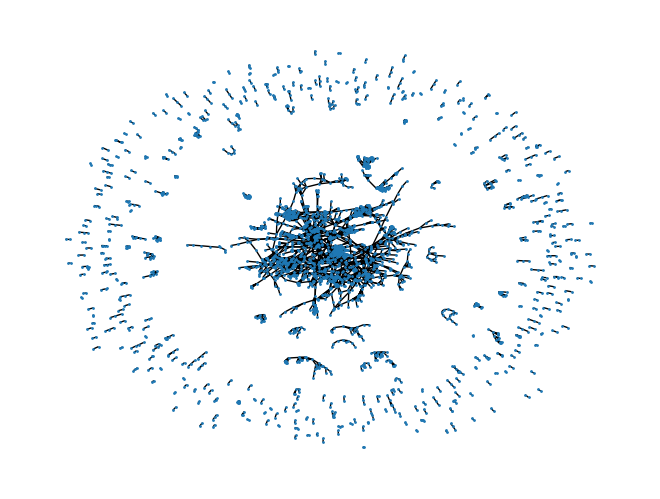

In [77]:
from matplotlib import pyplot as plt
def construct_network_dict (people):
    
    network = nx.Graph()    
    
    for person in people:
        for link in people[person]["links"]:
            if link != person : 
                network.add_node(person, attr_dict = people[person])
                network.add_node(link, attr_dict = people[link])
                network.add_edge(person, link)     
    return network
                
net_dict = construct_network_dict (politicians)

plt.figure()
positions = nx.spring_layout(net_dict)
nx.draw(net_dict, positions, node_size=1)

The network has:
1573 nodes
5736 edges
7.293070565797839 average degree
0.339796557267688 average clustering coefficient
6.817727056393223 average shortest path lenght


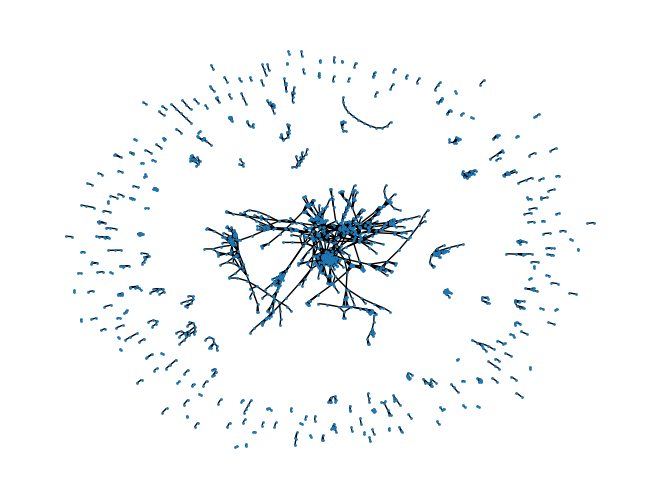

In [78]:
def construct_network_dictFM (people):
    
    network = nx.Graph()    
    
    for person in people:
        if people[person]["gender"] == ("F") or people[person]["gender"] == ("M"):
            for link in people[person]["links"]:
                if (link != person) and (people[link]["gender"] == ("F") or people[link]["gender"] == ("M")): 
                    network.add_node(person, attr_dict = people[person])
                    network.add_node(link, attr_dict = people[link])
                    network.add_edge(person, link)    

    return network
                
net_dictFM = construct_network_dictFM (politicians)

print("The network has:")
print(len(net_dictFM), "nodes")
print(net_dictFM.number_of_edges(), "edges")
print(2*net_dictFM.number_of_edges()/len(net_dictFM), "average degree")
print(nx.average_clustering(net_dictFM), "average clustering coefficient")
print(nx.average_shortest_path_length(net_dictFM.subgraph(max(nx.connected_components(net_dictFM), key=len))), "average shortest path lenght")

plt.figure()
positions = nx.spring_layout(net_dictFM)
nx.draw(net_dictFM, positions, node_size=1)

The network has:
2793 nodes
10294 edges
7.371285356247762 average degree
0.35382605730918215 average clustering coefficient
7.290627875646906 average shortest path lenght


Exception ignored in: <function tqdm.__del__ at 0x115015870>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/std.py", line 1162, in __del__
    
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/notebook.py", line 288, in close
    
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x115015870>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/std.py", line 1162, in __del__
    
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/notebook.py", line 288, in close
    
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


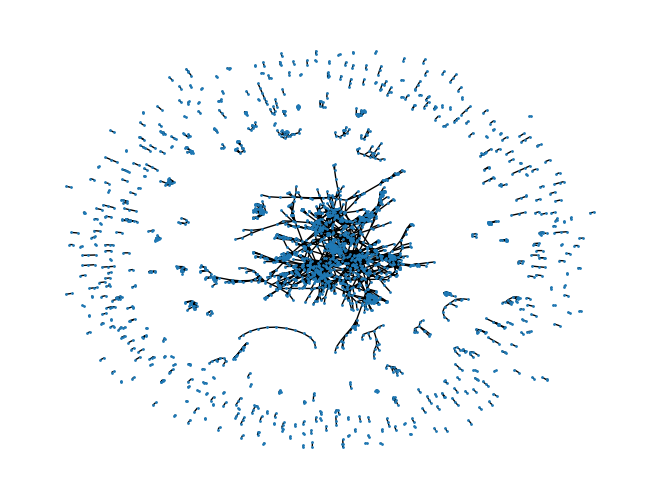

In [79]:
import networkx as nx

import numpy as np
import json

# Construct the network out of the post file
network = construct_network (politicians)

# Print out some basic statistics of the network
print("The network has:")
print(len(network), "nodes")
print(network.number_of_edges(), "edges")
print(2*network.number_of_edges()/len(network), "average degree")
print(nx.average_clustering(network), "average clustering coefficient")
print(nx.average_shortest_path_length(network.subgraph(max(nx.connected_components(network), key=len))), "average shortest path lenght")

# Plot the network
plt.figure()
positions = nx.spring_layout(network)
nx.draw(network, positions, node_size=1)

In [80]:
def construct_network2 (people):
    network2 = nx.Graph()  
    for person in people:
        #if len(people[person]["links"]) == 0:
        if "links" not in people[person]:
            #print ("no links")
            network2.add_node (person)
        else:
            for link in people[person]["links"]:

                if link != person :

                    gender = people[person]["gender"]
                    genderL = people[link]["gender"]
                    network2.add_edge(person, link)
                
    return network2

In [81]:
# Construct the network out of the post file
network2 = construct_network2 (people)
#network2 = construct_network2 (politicians)

# Print out some basic statistics of the network
print("The network has:")
print(len(network2), "nodes")
print(network2.number_of_edges(), "edges")
print(2*network2.number_of_edges()/len(network2), "average degree")

print(nx.average_clustering(network2), "average clustering coefficient")
print(nx.average_shortest_path_length(network2.subgraph(max(nx.connected_components(network2), key=len))), "average shortest path lenght")

# Plot the network
#plt.figure()
#positions = nx.spring_layout(network2)
#nx.draw(network2, positions, node_size=1)

The network has:
25 nodes
21 edges
1.68 average degree
0.26133333333333336 average clustering coefficient
2.311111111111111 average shortest path lenght


In [82]:
def MaleFemaleDivision (people):

    females = {}
    males = {}

    for pe in list(people.keys()):
        if people[pe]["gender"] == "F":
            females [pe] = people[pe]
        else:
            if people[pe]["gender"] == "M":
                males [pe] = people[pe]
    
    return males, females

male_politicians, female_politicians = MaleFemaleDivision(politicians)
            
print (len(female_politicians))
print (len(male_politicians))
print (len(female_politicians)+len(male_politicians))

386
2835
3221


In [83]:
male_degree = nx.degree(network, male_politicians)

female_degree = nx.degree(network, female_politicians)

# Compute the average degree for males and females
average_male_degree = sum(dict(male_degree).values()) / len(male_politicians)
average_female_degree = sum(dict(female_degree).values()) / len(female_politicians)
print(average_male_degree)
print(average_female_degree)

4.087830687830688
7.176165803108808


In [ ]:
#print(converted_dict)

#idf

def idf(people):
    allwords = All_words(people)
    idf = {}
    
    sorted_words = sorted(allwords.items(), key=lambda x:x[1], reverse = True)
    converted_dict = dict(sorted_words)
    
    for word in converted_dict.keys():
        idf [word]= math.log(len(people)/converted_dict[word])

    sorted_idf = sorted(idf.items(), key=lambda x:x[1], reverse = True)
    converted_dict_idf = dict(sorted_idf)
    
    return converted_dict_idf
    
converted_dict_idf_polit = idf (politicians)
print (converted_dict_idf_polit)

In [37]:
#FEMALES

def tf_females_fun(females):
    allwords_females={}
    for name,data in females.items():
        summary=data["summary"]
        for word in summary.split(" "): 
            word=word.strip().strip(".,").lower() 
            allwords_females[word]=allwords_females.get(word,0)+1 

    sorted_words_females = sorted(allwords_females.items(), key=lambda x:x[1], reverse = True)
    converted_dict_females = dict(sorted_words_females)

    tf_females = {}
    for word in converted_dict_females.keys():
        tf_females [word] = converted_dict_females[word]/len(females)
    return allwords_females, tf_females
    
allwords_female_politicians, tf_female_politicians = tf_females_fun(female_politicians)     
print (tf_female_politicians)

{'the': 5.9404145077720205, 'of': 4.295336787564767, 'and': 3.010362694300518, 'in': 2.7357512953367875, 'she': 2.494818652849741, 'a': 2.476683937823834, 'was': 1.854922279792746, 'to': 1.6269430051813472, 'as': 1.3704663212435233, 'is': 1.2461139896373057, 'for': 1.1865284974093264, 'from': 1.0129533678756477, 'her': 0.8808290155440415, 'politician': 0.7927461139896373, 'member': 0.7409326424870466, 'party': 0.6191709844559585, 'on': 0.5932642487046632, 'an': 0.5492227979274611, 'served': 0.5414507772020726, '(born': 0.47668393782383417, 'minister': 0.42487046632124353, 'elected': 0.35233160621761656, 'former': 0.32642487046632124, 'with': 0.31865284974093266, 'first': 0.31865284974093266, 'has': 0.3134715025906736, 'who': 0.30310880829015546, 'until': 0.3005181347150259, '': 0.29015544041450775, 'also': 0.27979274611398963, 'may': 0.2772020725388601, 'by': 0.2772020725388601, 'election': 0.27202072538860106, 'state': 0.266839378238342, '–': 0.26424870466321243, 'parliament': 0.26424

In [38]:
#MALES

def tf_males_fun (males):
    allwords_males={}
    for name,data in males.items():
        summary=data["summary"]
        for word in summary.split(" "): 
            word=word.strip().strip(".,").lower() 
            allwords_males[word]=allwords_males.get(word,0)+1 

    sorted_words_males = sorted(allwords_males.items(), key=lambda x:x[1], reverse = True)
    converted_dict_males = dict(sorted_words_males)

    tf_males = {}
    for word in converted_dict_males.keys():
        tf_males [word] = converted_dict_males[word]/len(males)
    return allwords_males, tf_males

allwords_male_politicians, tf_male_politicians = tf_males_fun(male_politicians)
print (tf_male_politicians)

{'the': 6.313227513227513, 'of': 4.756613756613756, 'and': 3.4991181657848323, 'in': 3.075485008818342, 'a': 2.5520282186948853, 'was': 2.468430335097002, 'he': 2.291710758377425, 'to': 1.5858906525573193, 'as': 1.4934744268077602, 'for': 1.0045855379188713, 'from': 0.9707231040564374, 'his': 0.9499118165784832, 'politician': 0.745326278659612, 'is': 0.6765432098765433, 'on': 0.6306878306878307, '–': 0.581657848324515, 'member': 0.5537918871252204, 'an': 0.5372134038800706, 'served': 0.5040564373897707, 'party': 0.46984126984126984, 'minister': 0.42680776014109345, 'at': 0.37883597883597886, 'with': 0.35167548500881834, 'by': 0.3470899470899471, 'who': 0.30970017636684305, '': 0.3075837742504409, 'also': 0.2948853615520282, 'until': 0.29065255731922396, 'after': 0.2656084656084656, 'state': 0.23209876543209876, 'cabinet': 0.23209876543209876, '(born': 0.23139329805996472, 'elected': 0.22680776014109347, 'became': 0.2257495590828924, 'president': 0.2257495590828924, 'that': 0.2253968253

In [39]:
# tf_ifd
tf_idf_females = {}
for word in tf_female_politicians:
    tf_idf_females[word] = tf_female_politicians[word]*converted_dict_idf_polit[word]

sorted_tf_idf_females = sorted(tf_idf_females.items(), key=lambda x:x[1], reverse = True)
converted_dict_tf_idf_females = dict(sorted_tf_idf_females)
print (converted_dict_tf_idf_females)

{'she': 3.0073226375273676, 'her': 2.2399082427655665, 'former': 0.6639413863160308, 'elected': 0.6281326313673183, 'member': 0.6159673774067872, 'has': 0.6105802539761792, 'woman': 0.604176639238746, 'first': 0.5758969510716593, 'an': 0.5378429378167827, "women's": 0.5321429237241317, '2011': 0.5271252360028914, 'film': 0.5251286431878416, 'on': 0.5238853078239206, 'since': 0.52098948917638, 'election': 0.5205742335295536, 'cabinet': 0.5171395049213184, 'until': 0.5120457512824147, 'minister': 0.5060106268543937, 'parliament': 0.5049208053091346, 'actress': 0.4991992355774022, 'district': 0.4901104153570429, 'that': 0.4896389951241561, 'may': 0.47904115973563677, 'representatives': 0.45756839499848806, 'who': 0.45627381919151444, 'for': 0.4460905211229079, 'women': 0.43739087420964795, '2007': 0.43520657243738964, 'also': 0.42172606483296937, 'house': 0.4213457503784703, '': 0.4155301011494652, 'state': 0.41529964984054335, 'after': 0.4126761514433208, 'president': 0.4109072713998308,

## Exercise C

Test if there is homophily related to gender in the politician network. 

- Find the number of links between the different genders
- compare it to the baseline case if nodes would have been randomly linking to each other 
(while keeping the degrees of the nodes fixed). 

Estimate the number of links between genders in the baseline case either via a simple pen-and-paper computation or by randomising the network explicitly.

In [84]:
male_female_links = 0
for node in network.nodes():
    if politicians[node]["gender"] == 'M':
        for link in politicians[node]["links"]:
            if (politicians[link]["gender"] == 'F'):
                male_female_links += 1

print (male_female_links)

1516


In [85]:
generic_links = 0
links = []
for node in network.nodes():
    for link in politicians[node]["links"]:
        if (link, node) not in links:

            generic_links += 1
            links.append((node, link))

print (len(links))
print (generic_links)

10331
10331


Replicate the analysis of comparing if females/males are more likely to be “local heroes,” i.e., if it is true that females are more likely to be in a larger number of language editions than males.

In [86]:
#Local heroes if < 2 languages
Local_heroes_bound = 2
Female_local_heroes = 0
Male_local_heroes = 0

for node in network.nodes():
    if politicians[node]["gender"] == 'M':
        if len(politicians[node]["langs"]) < Local_heroes_bound:
            Male_local_heroes +=1

print (Male_local_heroes)
print (Male_local_heroes/len(male_politicians))

for node in network.nodes():
    if politicians[node]["gender"] == 'F':
        if len(politicians[node]["langs"]) < Local_heroes_bound:
            Female_local_heroes +=1

print (Female_local_heroes)
print (Female_local_heroes/len(female_politicians))


293
0.10335097001763668
37
0.09585492227979274


Explore how the language used to describe men and women in their summary texts differs. It can be done by counting gendered words (e.g., she, her, wife) or comparing the usage of terms related to personal life (e.g., father, daughter, married) with professional terms’ usage (e.g., leader, president, politician).

In [87]:
#politicians
def gender_words_female(allwords):
    #gender words: she, her, wife
    female_gender_words = 0

    female_gender_words += allwords["she"]
    female_gender_words += allwords["her"]
    female_gender_words += allwords["wife"]
    female_gender_words += allwords["mother"]

    return female_gender_words
    
female_gender_words_politicians = gender_words_female(allwords_female_politicians)
female_gender_words_average_politicians = female_gender_words_politicians/len(female_politicians)

print("female gender words in politicians: ", female_gender_words_politicians)
print("female gender words average in politicians: ", female_gender_words_average_politicians)

#personal life: father, daughter, married, husband, son

def pers_words_females(allwords):
    female_pers_life_words = 0

    female_pers_life_words += allwords["father"]
    female_pers_life_words += allwords["daughter"]
    female_pers_life_words += allwords["married"]
    female_pers_life_words += allwords["husband"]
    female_pers_life_words += allwords["son"]

    return female_pers_life_words

female_pers_life_words_politicians = pers_words_females(allwords_female_politicians)

female_pers_life_words_average_politicians = female_pers_life_words_politicians/len(female_politicians)

print("female personal life words: ", female_pers_life_words_politicians)
print("female personal life words average: ", female_pers_life_words_average_politicians)

#professional terms: leader, president, politician

def pro_words_females(allwords):
    female_pro_life_words = 0

    female_pro_life_words += allwords["leader"]
    female_pro_life_words += allwords["president"]
    female_pro_life_words += allwords["politician"]
    
    return female_pro_life_words

female_pro_life_words_politicians = pro_words_females(allwords_female_politicians)

female_pro_life_words_average_politicians = female_pro_life_words_politicians/len(female_politicians)

print("female professional life words: ", female_pro_life_words_politicians)
print("female professional life words average: ", female_pro_life_words_average_politicians)

female gender words in politicians:  1324
female gender words average in politicians:  3.430051813471503
female personal life words:  62
female personal life words average:  0.16062176165803108
female professional life words:  458
female professional life words average:  1.1865284974093264


In [88]:
#gender words: he, him, husband, father

def gender_words_male(allwords):
    male_gender_words = 0

    male_gender_words += allwords["he"]
    male_gender_words += allwords["him"]
    male_gender_words += allwords["husband"]
    male_gender_words += allwords["father"]

    return male_gender_words

male_gender_words_politicians = gender_words_male(allwords_male_politicians)
male_gender_words_average_politicians = male_gender_words_politicians/len(male_politicians)

print("male gender words: ", male_gender_words_politicians)
print("male gender words average: ", male_gender_words_average_politicians)

#personal life: mother, daughter, married, wife, son

def pers_words_males(allwords):
    male_pers_life_words = 0

    male_pers_life_words += allwords["mother"]
    male_pers_life_words += allwords["daughter"]
    male_pers_life_words += allwords["married"]
    male_pers_life_words += allwords["wife"]
    male_pers_life_words += allwords["son"]

    return male_pers_life_words
    
male_pers_life_words_politicians = pers_words_males(allwords_male_politicians)
male_pers_life_words_average_politicians = male_pers_life_words_politicians/len(male_politicians)

print("male personal life words: ", male_pers_life_words_politicians)
print("male personal life words average: ", male_pers_life_words_average_politicians)

#professional terms: leader, president, politician

def pro_words_males(allwords):
    male_pro_life_words = 0

    male_pro_life_words += allwords["leader"]
    male_pro_life_words += allwords["president"]
    male_pro_life_words += allwords["politician"]
    
    return male_pro_life_words

male_pro_life_words_politicians = pro_words_males(allwords_male_politicians)
male_pro_life_words_average_politicians = male_pro_life_words_politicians/len(male_politicians)

print("male professional life words: ", male_pro_life_words_politicians)
print("male professional life words average: ", male_pro_life_words_average_politicians)

male gender words:  6927
male gender words average:  2.4433862433862434
male personal life words:  517
male personal life words average:  0.18236331569664904
male professional life words:  3248
male professional life words average:  1.145679012345679


Visualise the network structure between the politicians.

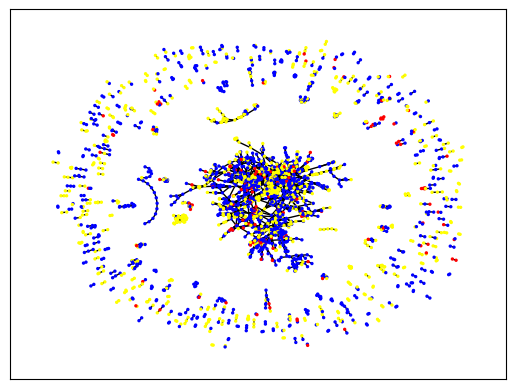

In [89]:
node_colors = []
for node in net_dict.nodes():
    if net_dict.nodes[node]["attr_dict"]["gender"] == "M":
        node_colors.append("blue")
    elif net_dict.nodes[node]["attr_dict"]["gender"] == "F":
        node_colors.append("red")
    else :
        node_colors.append("yellow")

# Draw the network graph
pos = nx.spring_layout(net_dict)  # Choose a layout algorithm
nx.draw_networkx(net_dict, pos=pos, node_size = 2, node_color=node_colors, with_labels=False)

# Show the plot
plt.show()

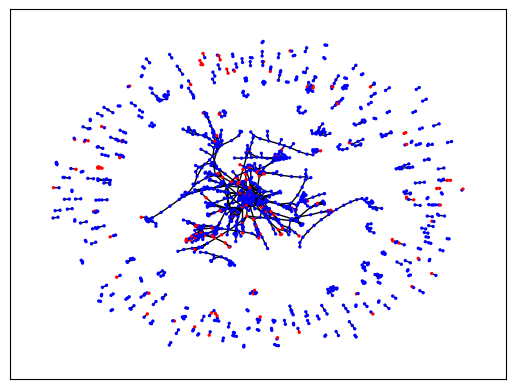

In [90]:
#division per gender

node_colors = []
for node in net_dictFM.nodes():
    if net_dictFM.nodes[node]["attr_dict"]["gender"] == "M":
        node_colors.append("blue")
    elif net_dictFM.nodes[node]["attr_dict"]["gender"] == "F":
        node_colors.append("red")
        
        
# Draw the network graph
pos = nx.spring_layout(net_dictFM)  # Choose a layout algorithm
nx.draw_networkx(net_dictFM, pos=pos, node_size = 2, node_color=node_colors, with_labels=False)

# Show the plot
plt.show()

Find the most central nodes in the network. It could be analyzed how centrality is related to gender and other attributes.

In [49]:
centr_degree = nx.degree_centrality(net_dict)
centr_degree_sorted=dict(sorted(centr_degree.items(), key=lambda item: item[1],reverse=True))
print (centr_degree_sorted)

{'Stef_Blok': 0.04656160458452722, 'Piet_Hein_Donner': 0.03868194842406877, 'André_Rouvoet': 0.03832378223495702, 'Halbe_Zijlstra': 0.03832378223495702, 'Henk_Kamp': 0.03832378223495702, 'Carola_Schouten': 0.03796561604584527, 'Wouter_Bos': 0.03796561604584527, 'Ronald_Plasterk': 0.03796561604584527, 'Johan_Remkes': 0.037607449856733526, 'Geert_Wilders': 0.036891117478510024, 'Alexander_Pechtold': 0.036891117478510024, 'Jetta_Klijnsma': 0.03474212034383954, 'Edith_Schippers': 0.034383954154727794, 'Fred_Teeven': 0.03402578796561605, 'Jeanine_Hennis-Plasschaert': 0.033309455587392546, 'Jan_Kees_de_Jager': 0.0329512893982808, 'Job_Cohen': 0.0329512893982808, 'Frans_Weekers': 0.0329512893982808, 'Hanke_Bruins_Slot': 0.0329512893982808, 'Joop_Atsma': 0.0329512893982808, 'Khadija_Arib': 0.0329512893982808, 'Atzo_Nicolaï': 0.03259312320916905, 'Martijn_van_Dam': 0.03259312320916905, 'Ank_Bijleveld': 0.03187679083094556, 'Gerda_Verburg': 0.03187679083094556, 'Kees_van_der_Staaij': 0.031876790

2793


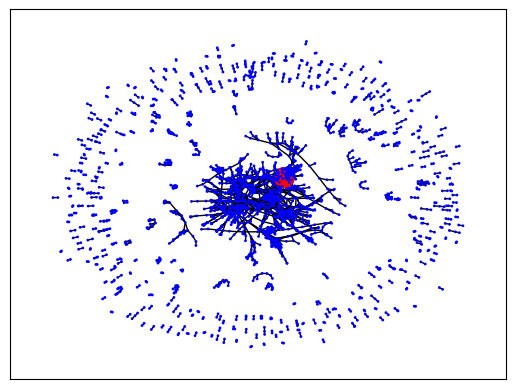

In [50]:
color_list = []
node_sizes = []
print(len(centr_degree_sorted))
for i in range(0, len(centr_degree_sorted)):
    if i == 0:
        color_list.append("red")
        node_sizes.append(200)
    elif i != 0:
        color_list.append("blue")
        node_sizes.append(1)

        
# Draw the network graph
pos = nx.spring_layout(net_dict)  # Choose a layout algorithm
nx.draw_networkx(net_dict, pos=pos, node_size = node_sizes, node_color=color_list, with_labels=False)

# Show the plot
plt.show()

# Journalists

In [91]:
Journalists = filter_persons_by(occupation = "journalist")
print (len (Journalists))

first_key = next(iter(Journalists))
first_value = Journalists[first_key]

print(first_key)  # Output: key1
print(first_value)  # Output: value1

6996
Wendy_Bouchard
{'#DBpURL': 'http://dbpedia.org/resource/Wendy_Bouchard', 'ID': '309', 'WikiURL': 'http://en.wikipedia.org/wiki/Wendy_Bouchard', 'gender': 'NA', 'name': "[' wendy bouchard ', ' bouchard wendy ']", 'birthDate': "[' 1980-06-22 ']", 'deathDate': 'NA', 'occupation': "[' journalist ', ' radio personality ', ' television presenter ', ' journalistradio presentertelevision presenter ']", 'nationality': 'NA', 'party': 'NA'}


In [92]:
Writers = filter_persons_by(occupation = "writer")
print (len (Writers))

first_key = next(iter(Writers))
first_value = Writers[first_key]

print(first_key)  # Output: key1
print(first_value)  # Output: value1

24370
Hans_Weiss_(author)
{'#DBpURL': 'http://dbpedia.org/resource/Hans_Weiss_(author)', 'ID': '6', 'WikiURL': 'http://en.wikipedia.org/wiki/Hans_Weiss_(author)', 'gender': 'NA', 'name': "[' hans weiss ', ' weiss hans ']", 'birthDate': 'NA', 'deathDate': 'NA', 'occupation': "[' * writer ']", 'nationality': "[' austria ']", 'party': 'NA'}


In [93]:
ensure_gender_data()

In [94]:
gender_data = get_genderdata()

In [95]:
filename="Journalists.json"


while fetch_links(Journalists ,batch_size=6996): save_people_json(Journalists,filename)
while fetch_summaries(Journalists,batch_size=6996): save_people_json(Journalists,filename)
while fetch_langs(Journalists,batch_size=6996): save_people_json(Journalists,filename)

save_people_json(Journalists,filename)

Fetching link data from Wikipedia


100%|██████████| 6996/6996 [37:00<00:00,  3.15it/s]


Fetching link data from Wikipedia


100%|██████████| 6996/6996 [00:00<00:00, 868737.63it/s]


Fetching summary text data from Wikipedia


 59%|█████▉    | 4149/6996 [27:54<15:28,  3.06it/s]  

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/urllib3/connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/urllib3/connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/http/client.py", line 1374, in getresponse
    response.begin()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/http/client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socket.py", line 7

In [96]:
filename="Journalists.json"
    
Journalists=load_people_json(filename)

firstKey = next(iter(Journalists)) 
print (Journalists[firstKey])

{'#DBpURL': 'http://dbpedia.org/resource/Wendy_Bouchard', 'ID': '309', 'WikiURL': 'http://en.wikipedia.org/wiki/Wendy_Bouchard', 'gender': 'NA', 'name': "[' wendy bouchard ', ' bouchard wendy ']", 'birthDate': "[' 1980-06-22 ']", 'deathDate': 'NA', 'occupation': "[' journalist ', ' radio personality ', ' television presenter ', ' journalistradio presentertelevision presenter ']", 'nationality': 'NA', 'party': 'NA', 'links': ['Mélissa_Theuriau']}


In [97]:
fill_in_genders(Journalists)

In [36]:
female_journalists = 0
male_journalists = 0 
NA_journalists = 0
for journalist in Journalists: 
    if Journalists[journalist]["gender"] == "F":
        female_journalists +=1
    elif Journalists[journalist]["gender"] == "M":
        male_journalists +=1
    elif Journalists[journalist]["gender"] == "NA":
        NA_journalists += 1

print (len(Journalists))
print ("number of female journalists:", female_journalists)
print ("number of male journalists:", male_journalists)
print ("number of NA journalists:", NA_journalists)

6996
number of female journalists: 1404
number of male journalists: 3661
number of NA journalists: 1931


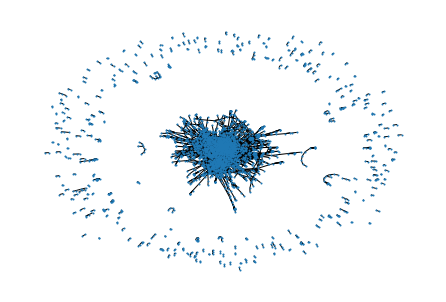

In [37]:
net_journalists = construct_network(Journalists)

plt.figure()
positions = nx.spring_layout(net_journalists)
nx.draw(net_journalists, positions, node_size=1)

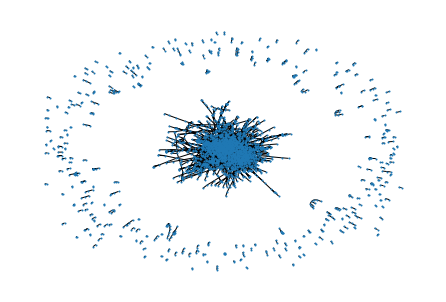

In [38]:
network_journalists = construct_network_dict(Journalists)

plt.figure()
positions = nx.spring_layout(network_journalists)
nx.draw(network_journalists, positions, node_size=1)

The network has:
2571 nodes
12732 edges
16.188175460902734 average degree
0.30814724785921754 average clustering coefficient
5.5214827179483645 average shortest path lenght


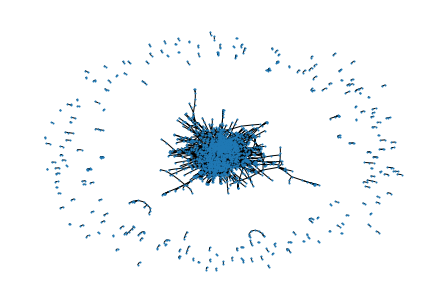

In [39]:
net_dictFM_Journalists = construct_network_dictFM (Journalists)

print("The network has:")
print(len(net_dictFM_Journalists), "nodes")
print(net_dictFM_Journalists.number_of_edges(), "edges")
print(2*net_dictFM_Journalists.number_of_edges()/len(net_dictFM), "average degree")
print(nx.average_clustering(net_dictFM_Journalists), "average clustering coefficient")
print(nx.average_shortest_path_length(net_dictFM_Journalists.subgraph(max(nx.connected_components(net_dictFM_Journalists), key=len))), "average shortest path lenght")

plt.figure()
positions = nx.spring_layout(net_dictFM_Journalists)
nx.draw(net_dictFM_Journalists, positions, node_size=1)

In [40]:
male_journalists, female_journalists = MaleFemaleDivision(Journalists)
            
print (len(female_journalists))
print (len(male_journalists))
print (len(female_journalists)+len(male_journalists))

1404
3661
5065


In [41]:
male_degree_journalists = nx.degree(net_journalists, male_journalists)

female_degree_journalists = nx.degree(net_journalists, female_journalists)

# Compute the average degree for males and females
average_male_degree = sum(dict(male_degree_journalists).values()) / len(male_journalists)
average_female_degree = sum(dict(female_degree_journalists).values()) / len(female_journalists)
print(average_male_degree)
print(average_female_degree)

5.036055722480197
7.518518518518518


In [42]:
converted_dict_idf_journ = idf (Journalists)
print (converted_dict_idf_journ)

{'bouchard': 8.853093836138493, 'tract': 8.853093836138493, 'cunliffe': 8.853093836138493, 'newly-established': 8.853093836138493, 'swerdlow': 8.853093836138493, 'heal': 8.853093836138493, 'scruggs': 8.853093836138493, '1998–1999': 8.853093836138493, 'sydell': 8.853093836138493, 'mariana': 8.853093836138493, 'wooley': 8.853093836138493, 'scottish-australian': 8.853093836138493, "nine's": 8.853093836138493, 'mcelhinney': 8.853093836138493, 'phelim': 8.853093836138493, 'mcaleer': 8.853093836138493, 'fracknation': 8.853093836138493, "tristan's": 8.853093836138493, 'kermit': 8.853093836138493, 'gosnell': 8.853093836138493, 'america’s': 8.853093836138493, 'nugent': 8.853093836138493, 'searchers': 8.853093836138493, 'eloise': 8.853093836138493, 'spaeth': 8.853093836138493, 'cuthbert': 8.853093836138493, 'blayne': 8.853093836138493, 'kyle.\nbefore': 8.853093836138493, 'gustines': 8.853093836138493, 'times.\nas': 8.853093836138493, 'circuits': 8.853093836138493, '(technology)': 8.8530938361384

In [43]:
allwords_female_journalists, tf_female_journalists = tf_females_fun(female_journalists)     
print (tf_female_journalists)

{'the': 3.891025641025641, 'and': 3.1103988603988606, 'of': 2.081908831908832, 'a': 1.9401709401709402, 'in': 1.933048433048433, 'she': 1.7393162393162394, 'is': 1.3618233618233617, 'for': 1.23005698005698, 'was': 1.0747863247863247, 'to': 0.8290598290598291, 'her': 0.7849002849002849, 'journalist': 0.7841880341880342, 'as': 0.7756410256410257, 'an': 0.7720797720797721, 'on': 0.7564102564102564, 'news': 0.6011396011396012, '(born': 0.5178062678062678, 'has': 0.41951566951566954, 'from': 0.4081196581196581, 'american': 0.4066951566951567, 'television': 0.405982905982906, 'at': 0.38247863247863245, 'with': 0.38247863247863245, '': 0.31339031339031337, 'new': 0.28561253561253563, 'also': 0.2799145299145299, 'author': 0.23005698005698005, 'by': 0.22863247863247863, 'who': 0.202991452991453, 'first': 0.202991452991453, 'york': 0.19658119658119658, 'presenter': 0.19515669515669515, 'show': 0.18803418803418803, 'known': 0.1858974358974359, 'that': 0.18233618233618235, 'radio': 0.1816239316239

In [44]:
allwords_male_journalists, tf_male_journalists = tf_males_fun(male_journalists)     
print (tf_male_journalists)

{'the': 4.854411363015569, 'and': 3.394700901393062, 'of': 2.746790494400437, 'in': 2.425566785031412, 'a': 2.1319311663479925, 'he': 1.911226440863152, 'was': 1.5916416279705, 'for': 1.2788855503960666, 'to': 1.1065282709642175, 'is': 1.0521715378311938, 'his': 1.0101065282709643, 'as': 0.9306200491668943, 'journalist': 0.8057907675498498, 'an': 0.7519803332422835, 'on': 0.7298552308112538, 'from': 0.4709095875443868, 'at': 0.4444140945096968, '–': 0.4064463261403988, 'american': 0.40453428025129745, 'with': 0.40016388964763727, 'news': 0.3941546025676045, '(born': 0.38541382136028407, 'has': 0.3769461895656924, 'by': 0.3381589729582081, 'also': 0.3261403987981426, '': 0.32422835290904123, 'new': 0.2756077574433215, 'editor': 0.2736957115542202, 'who': 0.2603113903305108, 'known': 0.23490849494673585, 'television': 0.23408904670854958, 'author': 0.22534826550122916, 'that': 0.21879267959573886, 'which': 0.20131111718109806, 'writer': 0.19639442775198032, 'radio': 0.18000546298825457, 

In [45]:
tf_idf_females_journ = {}
for word in tf_female_journalists:
    tf_idf_females_journ[word] = tf_female_journalists[word]*converted_dict_idf_journ[word]

sorted_tf_idf_females_journ = sorted(tf_idf_females_journ.items(), key=lambda x:x[1], reverse = True)
converted_dict_tf_idf_females_journ = dict(sorted_tf_idf_females_journ)
print (converted_dict_tf_idf_females_journ)

{'she': 1.2719905201273898, 'her': 1.174348649820715, 'news': 0.5506897696223969, 'television': 0.5350031098331982, '(born': 0.4840603932203847, 'american': 0.42772231947908895, 'has': 0.4206066851513323, 'presenter': 0.41932918649699547, 'new': 0.40188321044413355, 'show': 0.40150735986774044, 'anchor': 0.3875792122146084, 'york': 0.3808505889971377, 'bbc': 0.3746663865331842, '': 0.36284039068160073, 'with': 0.3616114555886864, 'author': 0.35843738358639854, 'first': 0.3577082934520478, 'from': 0.3436655070039357, 'correspondent': 0.3399292483594947, 'at': 0.33184208720819647, 'host': 0.3318212073122183, 'reporter': 0.3295997052827611, 'also': 0.3281875844522648, 'radio': 0.31527886389487736, 'former': 0.3000068261818606, 'worked': 0.2979359313609921, 'been': 0.29580003999362225, 'born': 0.294794832586577, 'who': 0.29409700474276995, 'that': 0.2936152092708353, 'writer': 0.28929840430268555, 'known': 0.2861346354528583, 'national': 0.28092381015960566, 'award': 0.2750800957879308, 'p

In [46]:
male_female_links_journ = 0
for node in net_journalists.nodes():
    if Journalists[node]["gender"] == 'M':
        for link in Journalists[node]["links"]:
            if (Journalists[link]["gender"] == 'F'):
                male_female_links_journ += 1

print (male_female_links_journ)

4114


In [47]:
generic_links_journ = 0
links_journ = []
for node in net_journalists.nodes():
    for link in Journalists[node]["links"]:
        if (link, node) not in links_journ:

            generic_links_journ += 1
            links_journ.append((node, link))

print (len(links_journ))
print (generic_links_journ)

16754
16754


In [49]:
#Local heroes if < 3 languages
Local_heroes_bound = 3
Female_local_heroes_journalist = 0
Male_local_heroes_journalist = 0

for node in net_journalists.nodes():
    if Journalists[node]["gender"] == 'M':
        if len(Journalists[node]["langs"]) < Local_heroes_bound:
            Male_local_heroes_journalist +=1

print (Male_local_heroes_journalist)
print (Male_local_heroes_journalist/len(male_journalists))

for node in net_journalists.nodes():
    if Journalists[node]["gender"] == 'F':
        if len(Journalists[node]["langs"]) < Local_heroes_bound:
            Female_local_heroes_journalist +=1

print (Female_local_heroes_journalist)
print (Female_local_heroes_journalist/len(female_journalists))

846
0.23108440316853318
363
0.25854700854700857


In [50]:
#journalists
    
female_gender_words_journalists = gender_words_female(allwords_female_journalists)
female_gender_words_average_journalists = female_gender_words_journalists/len(female_journalists)

print("female gender words in journalists: ", female_gender_words_journalists)
print("female gender words average in journalists: ", female_gender_words_average_journalists)

#personal life: father, daughter, married, husband, son

female_pers_life_words_journalists = pers_words_females(allwords_female_journalists)

female_pers_life_words_average_journalists = female_pers_life_words_journalists/len(female_journalists)

print("female personal life words journalists: ", female_pers_life_words_journalists)
print("female personal life words average journalists: ", female_pers_life_words_average_journalists)

#professional terms: leader, editor, journalist, redactor

def pro_words_females_journalists(allwords):
    female_pro_life_words = 0

    female_pro_life_words += allwords["editor"]
    female_pro_life_words += allwords["journalist"]
    female_pro_life_words += allwords["leader"]
    
    return female_pro_life_words

female_pro_life_words_journalists = pro_words_females_journalists(allwords_female_journalists)

female_pro_life_words_average_journalists = female_pro_life_words_journalists/len(female_journalists)

print("female professional life words jouralists: ", female_pro_life_words_journalists)
print("female professional life words average jouralists: ", female_pro_life_words_average_journalists)

female gender words in journalists:  3581
female gender words average in journalists:  2.5505698005698005
female personal life words journalists:  130
female personal life words average journalists:  0.09259259259259259
female professional life words jouralists:  1360
female professional life words average jouralists:  0.9686609686609686


In [51]:
male_gender_words_journalists = gender_words_male(allwords_male_journalists)
male_gender_words_average_journalists = male_gender_words_journalists/len(male_journalists)

print("male gender words journalists: ", male_gender_words_journalists)
print("male gender words average journalists: ", male_gender_words_average_journalists)
#personal life: mother, daughter, married, wife, son

    
male_pers_life_words_journalists = pers_words_males(allwords_male_journalists)
male_pers_life_words_average_journalists = male_pers_life_words_journalists/len(male_journalists)

print("male personal life words journalists: ", male_pers_life_words_journalists)
print("male personal life words average journalists: ", male_pers_life_words_average_journalists)

#professional terms: leader, president, politician

def pro_words_males_journalists(allwords):
    male_pro_life_words = 0

    male_pro_life_words += allwords["editor"]
    male_pro_life_words += allwords["journalist"]
    male_pro_life_words += allwords["leader"]
    
    return male_pro_life_words

male_pro_life_words_journalists = pro_words_males_journalists(allwords_male_journalists)
male_pro_life_words_average_journalists = male_pro_life_words_journalists/len(male_journalists)

print("male professional life words journalists: ", male_pro_life_words_journalists)
print("male professional life words average journalists: ", male_pro_life_words_average_journalists)

male gender words journalists:  7402
male gender words average journalists:  2.021851953018301
male personal life words journalists:  357
male personal life words average journalists:  0.09751434034416825
male professional life words journalists:  4042
male professional life words average journalists:  1.1040699262496585


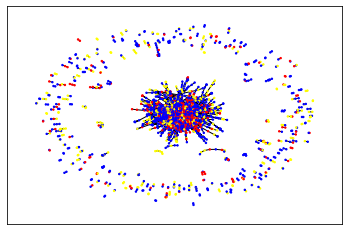

In [142]:
node_colors_journalists = []
for node in network_journalists.nodes():
    if network_journalists.nodes[node]["attr_dict"]["gender"] == "M":
        node_colors_journalists.append("blue")
    elif network_journalists.nodes[node]["attr_dict"]["gender"] == "F":
        node_colors_journalists.append("red")
    else :
        node_colors_journalists.append("yellow")

# Draw the network graph
pos = nx.spring_layout(network_journalists)  # Choose a layout algorithm
nx.draw_networkx(network_journalists, pos=pos, node_size = 2, node_color=node_colors_journalists, with_labels=False)

# Show the plot
plt.show()

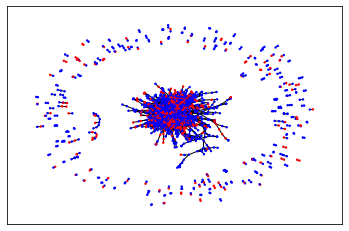

In [144]:
#division per gender

node_colors_journalists = []
for node in net_dictFM_Journalists.nodes():
    if net_dictFM_Journalists.nodes[node]["attr_dict"]["gender"] == "M":
        node_colors_journalists.append("blue")
    elif net_dictFM_Journalists.nodes[node]["attr_dict"]["gender"] == "F":
        node_colors_journalists.append("red")
        
        
# Draw the network graph
pos = nx.spring_layout(net_dictFM_Journalists)  # Choose a layout algorithm
nx.draw_networkx(net_dictFM_Journalists, pos=pos, node_size = 2, node_color=node_colors_journalists, with_labels=False)

# Show the plot
plt.show()

In [158]:
centr_degree_journalists = nx.degree_centrality(network_journalists)
centr_degree_sorted_journalists=dict(sorted(centr_degree_journalists.items(), key=lambda item: item[1],reverse=True))

for person in centr_degree_sorted_journalists:
    print (person, centr_degree_sorted_journalists[person], network_journalists.nodes[person]["attr_dict"]["gender"])

#print (centr_degree_sorted_journalists)

Anderson_Cooper 0.04085893229943335 M
Sanjay_Gupta 0.04085893229943335 M
John_Roberts_(journalist) 0.03966597077244259 M
Clarissa_Ward 0.03370116313748882 F
Alisyn_Camerota 0.033104682373993444 F
Sharyl_Attkisson 0.029824038174768867 F
Wolf_Blitzer 0.029824038174768867 M
Connie_Chung 0.02922755741127349 F
Peter_Arnett 0.02922755741127349 M
Stephanie_Sy 0.02922755741127349 NA
Brianna_Keilar 0.02863107664777811 F
Fareed_Zakaria 0.02863107664777811 M
Ali_Velshi 0.02863107664777811 M
Alison_Stewart 0.028332836266030424 F
Tony_Harris_(journalist) 0.027736355502535046 M
Brian_Stelter 0.027139874739039668 M
Chris_Cuomo 0.026245153593796602 M
Piers_Morgan 0.025648672830301224 M
Bob_Schieffer 0.025350432448553537 M
Scott_Pelley 0.025350432448553537 M
Bernard_Shaw_(journalist) 0.025350432448553537 M
Erin_Burnett 0.025350432448553537 F
Ed_Bradley 0.02475395168505816 M
Hugh_Riminton 0.02475395168505816 M
Carl_Bernstein 0.02475395168505816 M
Judy_Woodruff 0.02475395168505816 F
Norah_O'Donnell 0.024

3354


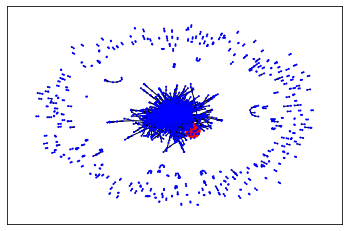

In [56]:
color_list_journalists = []
node_sizes_journalists = []
print(len(centr_degree_sorted_journalists))
for i in range(0, len(centr_degree_sorted_journalists)):
    if i == 0:
        color_list_journalists.append("red")
        node_sizes_journalists.append(200)
    elif i != 0:
        color_list_journalists.append("blue")
        node_sizes_journalists.append(1)

        
# Draw the network graph
pos = nx.spring_layout(network_journalists)  # Choose a layout algorithm
nx.draw_networkx(network_journalists, pos=pos, node_size = node_sizes_journalists, node_color=color_list_journalists, with_labels=False)

# Show the plot
plt.show()

# Italians

In [58]:
filename="italianWriters.json"
if not os.path.isfile(filename):
    people=filter_persons_by(occupation = "writer", nationality="italy")
    fill_in_genders(people)
    save_people_json(people,filename)
    
italians=load_people_json(filename)

print (len(italians))

94


In [59]:
while fetch_links(italians,batch_size=953): save_people_json(italians,filename)
while fetch_summaries(italians,batch_size=953): save_people_json(italians,filename)
while fetch_langs(italians,batch_size=953): save_people_json(italians,filename)

save_people_json(italians,filename)

Fetching link data from Wikipedia


  0%|          | 0/94 [00:00<?, ?it/s]

Fetching summary text data from Wikipedia


  0%|          | 0/94 [00:00<?, ?it/s]

Fetching language editions data from Wikipedia


  0%|          | 0/94 [00:00<?, ?it/s]

In [60]:
female_it_writers = 0
male_it_writers = 0 
NA_it_writers = 0
for it_writer in italians: 
    if italians[it_writer]["gender"] == "F":
        female_it_writers +=1
    elif italians[it_writer]["gender"] == "M":
        male_it_writers +=1
    elif italians[it_writer]["gender"] == "NA":
        NA_it_writers += 1

print (len(italians))
print ("number of female italian writers:", female_it_writers)
print ("number of male italian writers:", male_it_writers)
print ("number of NA italian writers:", NA_it_writers)

94
number of female italian writers: 3
number of male italian writers: 23
number of NA italian writers: 68


In [61]:
fill_in_genders(italians)

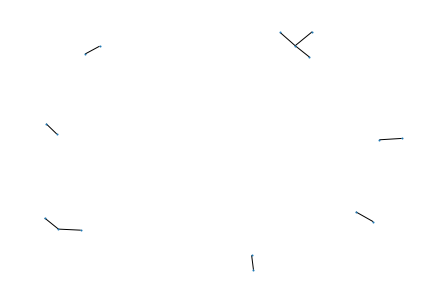

In [62]:
net_it_writers = construct_network(italians)

plt.figure()
positions = nx.spring_layout(net_it_writers)
nx.draw(net_it_writers, positions, node_size=1)

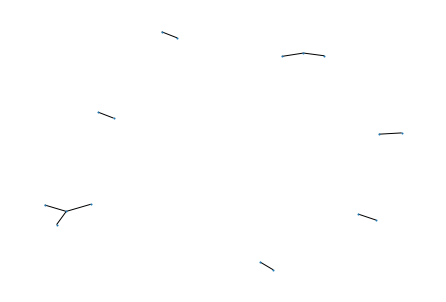

In [63]:
network_it_writers = construct_network_dict(italians)

plt.figure()
positions = nx.spring_layout(network_it_writers)
nx.draw(network_it_writers, positions, node_size=1)

The network has:
4 nodes
2 edges
1.0 average degree
0.0 average clustering coefficient
1.0 average shortest path lenght


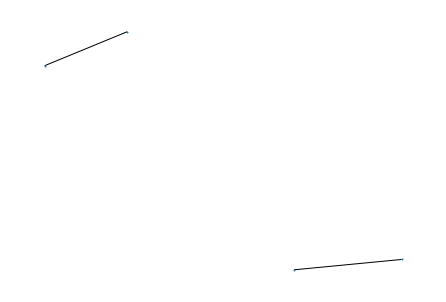

In [64]:
net_dictFM_it_writers = construct_network_dictFM (italians)

print("The network has:")
print(len(net_dictFM_it_writers), "nodes")
print(net_dictFM_it_writers.number_of_edges(), "edges")
print(2*net_dictFM_it_writers.number_of_edges()/len(net_dictFM_it_writers), "average degree")
print(nx.average_clustering(net_dictFM_it_writers), "average clustering coefficient")
print(nx.average_shortest_path_length(net_dictFM_it_writers.subgraph(max(nx.connected_components(net_dictFM_it_writers), key=len))), "average shortest path lenght")

plt.figure()
positions = nx.spring_layout(net_dictFM_it_writers)
nx.draw(net_dictFM_it_writers, positions, node_size=1)

In [65]:
male_it_writers, female_it_writers = MaleFemaleDivision(italians)
            
print (len(female_it_writers))
print (len(male_it_writers))
print (len(female_it_writers)+len(male_it_writers))

3
23
26


In [66]:
male_degree_it_writers = nx.degree(net_it_writers, male_it_writers)

female_degree_it_writers = nx.degree(net_it_writers, female_it_writers)

# Compute the average degree for males and females
average_male_degree_it_writers = sum(dict(male_degree_it_writers).values()) / len(male_it_writers)
average_female_degree_it_writers = sum(dict(female_degree_it_writers).values()) / len(female_it_writers)
print(average_male_degree_it_writers)
print(average_female_degree_it_writers)

0.391304347826087
0.3333333333333333


In [67]:
converted_dict_idf_it_writers = idf (italians)
print (converted_dict_idf_it_writers)

{'claudio': 4.543294782270004, 'bonivento': 4.543294782270004, '(italian': 4.543294782270004, 'pronunciation:': 4.543294782270004, '[roˈbɛrto': 4.543294782270004, 'amoˈroːzo;': 4.543294782270004, '-oːso];': 4.543294782270004, '1911–1994)': 4.543294782270004, 'came': 4.543294782270004, 'either': 4.543294782270004, 'shot': 4.543294782270004, 'saverio': 4.543294782270004, 'principini': 4.543294782270004, '(also': 4.543294782270004, '"sage")': 4.543294782270004, 'certified': 4.543294782270004, 'multi-platinum': 4.543294782270004, 'los': 4.543294782270004, 'angeles': 4.543294782270004, 'scene': 4.543294782270004, 'bergonzelli': 4.543294782270004, '1924': 4.543294782270004, '(1819–1891)': 4.543294782270004, 'genres': 4.543294782270004, 'successful': 4.543294782270004, 'blind': 4.543294782270004, 'sorrento': 4.543294782270004, '(1852)': 4.543294782270004, 'novels': 4.543294782270004, 'aldo': 4.543294782270004, 'von': 4.543294782270004, '(1913–1967)': 4.543294782270004, 'bracco': 4.54329478227

In [68]:
allwords_female_it_writers, tf_female_it_writers = tf_females_fun(female_it_writers)     
print (tf_female_it_writers)

{'an': 1.3333333333333333, 'italian': 1.3333333333333333, 'the': 1.3333333333333333, '(born': 0.6666666666666666, 'is': 0.6666666666666666, 'music': 0.6666666666666666, 'she': 0.6666666666666666, 'march': 0.6666666666666666, 'a': 0.6666666666666666, 'eleonora': 0.3333333333333333, 'giorgi': 0.3333333333333333, '21': 0.3333333333333333, 'october': 0.3333333333333333, '1953)': 0.3333333333333333, 'actress': 0.3333333333333333, 'simona': 0.3333333333333333, 'molinari': 0.3333333333333333, '23': 0.3333333333333333, 'february': 0.3333333333333333, '1983)': 0.3333333333333333, 'jazz': 0.3333333333333333, 'singer': 0.3333333333333333, 'performed': 0.3333333333333333, 'at': 0.3333333333333333, 'sanremo': 0.3333333333333333, 'festival': 0.3333333333333333, '2009': 0.3333333333333333, 'her': 0.3333333333333333, 'song': 0.3333333333333333, '"egocentrica"': 0.3333333333333333, 'shortly': 0.3333333333333333, 'after': 0.3333333333333333, 'released': 0.3333333333333333, 'album': 0.3333333333333333, '

In [69]:
allwords_male_it_writers, tf_male_it_writers = tf_males_fun(male_it_writers)     
print (tf_male_it_writers)

{'the': 2.1739130434782608, 'and': 2.0434782608695654, 'of': 1.7826086956521738, 'in': 1.2608695652173914, 'he': 1.2608695652173914, 'was': 1.1304347826086956, 'italian': 1.0869565217391304, 'an': 0.9130434782608695, 'a': 0.8695652173913043, 'his': 0.8260869565217391, 'is': 0.6956521739130435, 'film': 0.6086956521739131, 'to': 0.6086956521739131, 'director': 0.5652173913043478, 'as': 0.5217391304347826, 'for': 0.5217391304347826, '–': 0.4782608695652174, 'screenwriter': 0.391304347826087, '(born': 0.391304347826087, 'by': 0.391304347826087, 'march': 0.34782608695652173, 'on': 0.34782608695652173, 'at': 0.34782608695652173, 'writer': 0.30434782608695654, 'two': 0.2608695652173913, 'has': 0.2608695652173913, 'last': 0.2608695652173913, 'journalist': 0.2608695652173913, 'known': 0.21739130434782608, 'from': 0.21739130434782608, 'years': 0.21739130434782608, 'most': 0.21739130434782608, 'actor': 0.21739130434782608, 'january': 0.17391304347826086, 'member': 0.17391304347826086, 'with': 0.1

In [70]:
tf_idf_females_it_writers = {}
for word in tf_female_it_writers:
    tf_idf_females_it_writers[word] = tf_female_it_writers[word]*converted_dict_idf_it_writers[word]

sorted_tf_idf_females_it_writers = sorted(tf_idf_females_it_writers.items(), key=lambda x:x[1], reverse = True)
converted_dict_tf_idf_females_it_writers = dict(sorted_tf_idf_females_it_writers)
print (converted_dict_tf_idf_females_it_writers)

{'she': 1.834356875361299, 'music': 1.7315897554764605, 'giorgi': 1.5144315940900013, 'simona': 1.5144315940900013, 'molinari': 1.5144315940900013, 'jazz': 1.5144315940900013, 'performed': 1.5144315940900013, 'sanremo': 1.5144315940900013, '2009': 1.5144315940900013, '"egocentrica"': 1.5144315940900013, 'shortly': 1.5144315940900013, 'augusta': 1.5144315940900013, 'lagostena': 1.5144315940900013, '"tina"': 1.5144315940900013, 'bassi': 1.5144315940900013, '4': 1.5144315940900013, '2008)': 1.5144315940900013, 'lawyer': 1.5144315940900013, 'forza': 1.5144315940900013, 'italia': 1.5144315940900013, 'media': 1.5144315940900013, 'eleonora': 1.2833825339033527, '1953)': 1.2833825339033527, '1983)': 1.2833825339033527, 'released': 1.2833825339033527, 'same': 1.2833825339033527, '1926': 1.2833825339033527, 'deputy': 1.2833825339033527, 'party': 1.2833825339033527, '(2': 1.148227497867298, 'personality': 1.148227497867298, 'march': 1.1400542921425252, 'singer': 1.0523334737167045, 'festival': 1.

In [71]:
male_female_links_it_writers = 0
for node in net_it_writers.nodes():
    if italians[node]["gender"] == 'M':
        for link in italians[node]["links"]:
            if (italians[link]["gender"] == 'F'):
                male_female_links_it_writers += 1

print (male_female_links_it_writers)

0


In [75]:
generic_links_it_writers = 0
links_it_writers = []
for node in net_it_writers.nodes():
    for link in italians[node]["links"]:
        if (link, node) not in links_journ:

            generic_links_it_writers += 1
            links_it_writers.append((node, link))

print (len(links_it_writers))
print (generic_links_it_writers)

13
13


In [80]:
#Local heroes if < 3 languages
Local_heroes_bound = 3
Female_local_heroes_it_writers = 0
Male_local_heroes_it_writers = 0

for node in net_it_writers.nodes():
    if italians[node]["gender"] == 'M':
        if len(italians[node]["langs"]) < Local_heroes_bound:
            Male_local_heroes_it_writers +=1

print (Male_local_heroes_it_writers)
print (Male_local_heroes_it_writers/len(male_it_writers))

for node in net_it_writers.nodes():
    if italians[node]["gender"] == 'F':
        if len(italians[node]["langs"]) < Local_heroes_bound:
            Female_local_heroes_it_writers +=1

print (Female_local_heroes_it_writers)
print (Female_local_heroes_it_writers/len(female_it_writers))

0
0.0
0
0.0


## Italias born since 1970

In [83]:
filename="italians1970.json"
if not os.path.isfile(filename):
    people=filter_persons_by(nationality="italy", birth_more=1970)
    fill_in_genders(people)
    save_people_json(people,filename)
    
italians1970=load_people_json(filename)

print (len(italians1970))


717


In [84]:
while fetch_links(italians1970,batch_size=4643): save_people_json(italians1970,filename)
while fetch_summaries(italians1970,batch_size=4643): save_people_json(italians1970,filename)
while fetch_langs(italians1970,batch_size=4643): save_people_json(italians1970,filename)

save_people_json(italians1970,filename)

Fetching link data from Wikipedia


  0%|          | 0/717 [00:00<?, ?it/s]

Fetching summary text data from Wikipedia


  0%|          | 0/717 [00:00<?, ?it/s]

Fetching language editions data from Wikipedia


  0%|          | 0/717 [00:00<?, ?it/s]

In [85]:
fill_in_genders(italians1970)

In [86]:
female_ita1970 = 0
male_ita1970 = 0 
NA_ita1970 = 0
for italian in italians1970: 
    if italians1970[italian]["gender"] == "F":
        female_ita1970 +=1
    elif italians1970[italian]["gender"] == "M":
        male_ita1970 +=1
    elif italians1970[italian]["gender"] == "NA":
        NA_ita1970 += 1

print (len(italians1970))
print ("number of female journalists:", female_ita1970)
print ("number of male journalists:", male_ita1970)
print ("number of NA journalists:", NA_ita1970)

717
number of female journalists: 135
number of male journalists: 292
number of NA journalists: 290


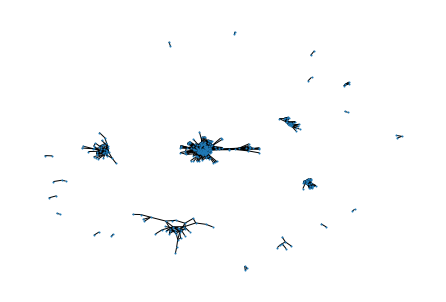

In [87]:
net_ita1970 = construct_network(italians1970)

plt.figure()
positions = nx.spring_layout(net_ita1970)
nx.draw(net_ita1970, positions, node_size=1)

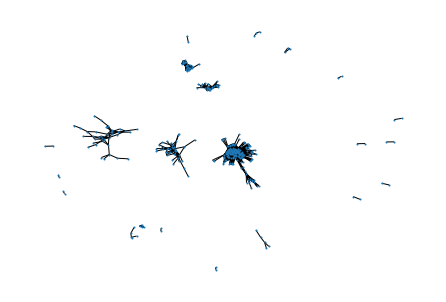

In [88]:
network_italians1970 = construct_network_dict(italians1970)

plt.figure()
positions = nx.spring_layout(network_italians1970)
nx.draw(network_italians1970, positions, node_size=1)

The network has:
248 nodes
1586 edges
12.790322580645162 average degree
0.5616938868071295 average clustering coefficient
2.383638672229276 average shortest path lenght


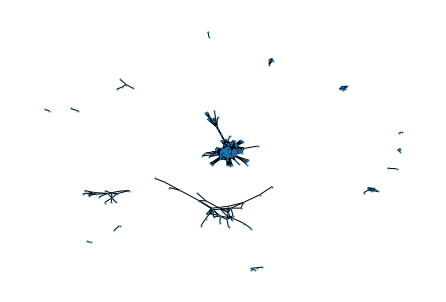

In [89]:
net_dictFM_ita1970 = construct_network_dictFM (italians1970)

print("The network has:")
print(len(net_dictFM_ita1970), "nodes")
print(net_dictFM_ita1970.number_of_edges(), "edges")
print(2*net_dictFM_ita1970.number_of_edges()/len(net_dictFM_ita1970), "average degree")
print(nx.average_clustering(net_dictFM_ita1970), "average clustering coefficient")
print(nx.average_shortest_path_length(net_dictFM_ita1970.subgraph(max(nx.connected_components(net_dictFM_ita1970), key=len))), "average shortest path lenght")

plt.figure()
positions = nx.spring_layout(net_dictFM_ita1970)
nx.draw(net_dictFM_ita1970, positions, node_size=1)

In [90]:
male_ita1970, female_ita1970 = MaleFemaleDivision(italians1970)
            
print (len(female_ita1970))
print (len(male_ita1970))
print (len(female_ita1970)+len(male_ita1970))

135
292
427


In [91]:
male_degree_ita1970 = nx.degree(net_ita1970, male_ita1970)

female_degree_ita1970 = nx.degree(net_ita1970, female_ita1970)

# Compute the average degree for males and females
average_male_degree = sum(dict(male_degree_ita1970).values()) / len(male_ita1970)
average_female_degree = sum(dict(female_degree_ita1970).values()) / len(female_ita1970)
print(average_male_degree)
print(average_female_degree)

7.623287671232877
9.88888888888889


In [92]:
converted_dict_idf_ita1970 = idf (italians1970)

In [93]:
allwords_female_ita1970, tf_female_ita1970 = tf_females_fun(female_ita1970)     
print (tf_female_ita1970)

{'the': 2.7037037037037037, 'in': 2.162962962962963, 'she': 1.3703703703703705, 'is': 1.2814814814814814, 'and': 1.1703703703703703, 'italian': 1.1407407407407408, 'a': 0.9851851851851852, 'of': 0.9481481481481482, '(born': 0.8666666666666667, 'an': 0.8444444444444444, 'at': 0.6814814814814815, 'was': 0.45925925925925926, 'her': 0.4148148148148148, 'for': 0.4, 'to': 0.3925925925925926, 'won': 0.362962962962963, 'as': 0.3111111111111111, 'italy': 0.2962962962962963, 'summer': 0.2740740740740741, 'world': 0.2740740740740741, 'who': 0.26666666666666666, 'olympics': 0.24444444444444444, 'has': 0.23703703703703705, 'team': 0.22962962962962963, "women's": 0.2222222222222222, 'championships': 0.2222222222222222, 'with': 0.21481481481481482, 'on': 0.2074074074074074, 'medal': 0.2, 'competed': 0.1925925925925926, 'national': 0.17777777777777778, 'by': 0.17037037037037037, 'march': 0.16296296296296298, 'silver': 0.15555555555555556, 'from': 0.15555555555555556, '2008': 0.14814814814814814, 'm': 

In [94]:
allwords_male_ita1970, tf_male_ita1970 = tf_males_fun(male_ita1970)     
print (tf_male_ita1970)

{'the': 3.01027397260274, 'in': 2.462328767123288, 'is': 1.3253424657534247, 'and': 1.2636986301369864, 'he': 1.1883561643835616, 'italian': 1.1369863013698631, 'of': 0.9212328767123288, 'a': 0.9006849315068494, '(born': 0.8835616438356164, 'an': 0.8116438356164384, 'at': 0.5136986301369864, 'for': 0.4726027397260274, '': 0.4452054794520548, 'championship': 0.4349315068493151, 'world': 0.4349315068493151, 'was': 0.4178082191780822, 'to': 0.4041095890410959, 'his': 0.3801369863013699, 'won': 0.3321917808219178, 'with': 0.3253424657534247, 'racing': 0.3150684931506849, 'team': 0.2465753424657534, 'european': 0.24315068493150685, 'from': 0.2363013698630137, 'driver': 0.2363013698630137, 'competed': 0.22945205479452055, 'as': 0.2226027397260274, 'has': 0.21575342465753425, 'who': 0.2054794520547945, 'on': 0.19863013698630136, 'italy': 0.1952054794520548, 'former': 0.18493150684931506, 'm': 0.1815068493150685, 'also': 0.17465753424657535, 'champion': 0.17123287671232876, 'by': 0.17123287671

In [98]:
tf_idf_females_ita1970 = {}
for word in tf_female_ita1970:
    tf_idf_females_ita1970[word] = tf_female_ita1970[word]*converted_dict_idf_ita1970[word]

sorted_tf_idf_females_ita1970 = sorted(tf_idf_females_ita1970.items(), key=lambda x:x[1], reverse = True)
converted_dict_tf_idf_females_ita1970 = dict(sorted_tf_idf_females_ita1970)
print (converted_dict_tf_idf_females_ita1970)

{'she': 1.1534881058136803, 'her': 0.7929752429874295, 'as': 0.5015830432167997, 'won': 0.49964712338782175, 'summer': 0.49922199282407753, 'at': 0.48483636429733445, 'was': 0.4694163544595273, 'olympics': 0.46046683426833873, 'to': 0.45851048640291553, 'medal': 0.45151754541266204, 'who': 0.4433122546302849, 'championships': 0.4333562282922998, 'marathon': 0.41294120420829594, "women's": 0.40286709017819206, 'has': 0.3923187946125026, 'italy': 0.3919414555712564, 'march': 0.38628467308585485, 'runner': 0.36486735160096473, 'paralympics': 0.3635705947388107, 'silver': 0.3597060387757363, 'by': 0.35356386604589013, 'on': 0.3525673962011639, 'for': 0.3405962954588959, '2008': 0.3344574410464163, 'm': 0.3267597019455702, '2012': 0.32639219407393716, 'competed': 0.31458717679813497, 'actress': 0.30983228371820914, 'two': 0.30871513209451834, 'sprinter': 0.30760148342547783, 'team': 0.3073900015619245, 'february': 0.3028014329860601, 'with': 0.29689963482646586, '2020': 0.29645472317578386,

In [99]:
male_female_links_ita1970 = 0
for node in net_ita1970.nodes():
    if italians1970[node]["gender"] == 'M':
        for link in italians1970[node]["links"]:
            if (italians1970[link]["gender"] == 'F'):
                male_female_links_ita1970 += 1

print (male_female_links_ita1970)

509


In [100]:
generic_links_ita1970 = 0
links_ita1970 = []
for node in net_ita1970.nodes():
    for link in italians1970[node]["links"]:
        if (link, node) not in links_ita1970:

            generic_links_ita1970 += 1
            links_ita1970.append((node, link))

print (len(links_ita1970))
print (generic_links_ita1970)

2119
2119


In [101]:
#Local heroes if < 3 languages
Local_heroes_bound = 3
Female_local_heroes_ita1970 = 0
Male_local_heroes_ita1970 = 0

for node in net_ita1970.nodes():
    if italians1970[node]["gender"] == 'M':
        if len(italians1970[node]["langs"]) < Local_heroes_bound:
            Male_local_heroes_ita1970 +=1

print (Male_local_heroes_ita1970)
print (Male_local_heroes_ita1970/len(male_ita1970))

for node in net_ita1970.nodes():
    if italians1970[node]["gender"] == 'F':
        if len(italians1970[node]["langs"]) < Local_heroes_bound:
            Female_local_heroes_ita1970 +=1

print (Female_local_heroes_ita1970)
print (Female_local_heroes_ita1970/len(female_ita1970))

26
0.08904109589041095
15
0.1111111111111111


In [140]:
#italians 1970
 
def gender_words_female_ita(allwords):
    #gender words: she, her, wife
    female_gender_words = 0

    female_gender_words += allwords["she"]
    female_gender_words += allwords["her"]
    female_gender_words += allwords["wife"]
    #female_gender_words += allwords["mother"]

    return female_gender_words
    
female_gender_words_ita1970 = gender_words_female_ita(allwords_female_ita1970)
female_gender_words_average_ita1970 = female_gender_words_ita1970/len(female_ita1970)

print("female gender words in italians born since 1970: ", female_gender_words_ita1970)
print("female gender words average in italians born since 1970: ", female_gender_words_average_ita1970)

#personal life: father, daughter, married, husband, son

def pers_words_females(allwords):
    female_pers_life_words = 0

    female_pers_life_words += allwords["father"]
    female_pers_life_words += allwords["daughter"]
    #female_pers_life_words += allwords["married"]
    female_pers_life_words += allwords["husband"]
    #female_pers_life_words += allwords["son"]

    return female_pers_life_words

female_pers_life_words_ita1970 = pers_words_females(allwords_female_ita1970)

female_pers_life_words_average_ita1970 = female_pers_life_words_ita1970/len(female_ita1970)

print("female personal life words journalists: ", female_pers_life_words_ita1970)
print("female personal life words average journalists: ", female_pers_life_words_average_ita1970)

#occupations

def occupations(people):

    occupations = {}
    for person in people: 
        if people[person]["occupation"] in occupations:
            occupations[people[person]["occupation"]] += 1
        else: 
            occupations[people[person]["occupation"]] = 1
    return occupations

occupations_females = occupations(female_ita1970)

print("occupations: ", occupations_females)

female gender words in italians born since 1970:  242
female gender words average in italians born since 1970:  1.7925925925925925
female personal life words journalists:  3
female personal life words average journalists:  0.022222222222222223
occupations:  {'NA': 115, "[' archery ', ' archer ']": 3, "[' journalist ']": 1, "[' showgirl television presenter ']": 1, "[' artist ', ' film producer ', ' artistfilm producer ']": 1, "[' professional dancer ']": 1, "[' tv host former actress ']": 1, "[' mountaineering ', ' nursemountaineer ']": 1, "[' singing ', ' songwriter ']": 1, "[' actor ', ' actress ']": 1, "[' synchronised swimming ', ' synchronised swimmer ']": 1, "[' actor ', ' singing ', ' actress/singer ']": 1, "[' television host ']": 1, "[' entrepreneur ']": 1, "[' actress ']": 1, "[' actress model television presenter ']": 1, "[' model and actress ']": 1, "[' ballet dancer ']": 1, "[' actress model and presenter ']": 1}


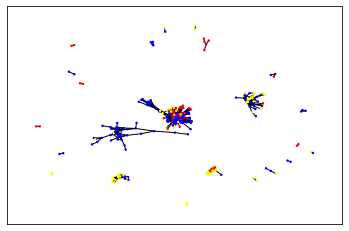

In [141]:
node_colors_ita1970 = []
for node in network_italians1970.nodes():
    if network_italians1970.nodes[node]["attr_dict"]["gender"] == "M":
        node_colors_ita1970.append("blue")
    elif network_italians1970.nodes[node]["attr_dict"]["gender"] == "F":
        node_colors_ita1970.append("red")
    else :
        node_colors_ita1970.append("yellow")

# Draw the network graph
pos = nx.spring_layout(network_italians1970)  # Choose a layout algorithm
nx.draw_networkx(network_italians1970, pos=pos, node_size = 2, node_color=node_colors_ita1970, with_labels=False)

# Show the plot
plt.show()

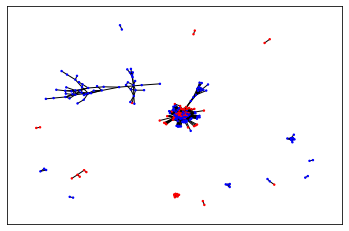

In [146]:
#division per gender

node_colors_ita1970 = []
for node in net_dictFM_ita1970.nodes():
    if net_dictFM_ita1970.nodes[node]["attr_dict"]["gender"] == "M":
        node_colors_ita1970.append("blue")
    elif net_dictFM_ita1970.nodes[node]["attr_dict"]["gender"] == "F":
        node_colors_ita1970.append("red")
        
# Draw the network graph
pos = nx.spring_layout(net_dictFM_ita1970)  # Choose a layout algorithm
nx.draw_networkx(net_dictFM_ita1970, pos=pos, node_size = 2, node_color=node_colors_ita1970, with_labels=False)

# Show the plot
plt.show()

In [157]:
centr_degree_ita1970 = nx.degree_centrality(network_italians1970)
centr_degree_sorted_ita1970=dict(sorted(centr_degree_ita1970.items(), key=lambda item: item[1],reverse=True))


for person in centr_degree_sorted_ita1970:
    print (person, centr_degree_sorted_ita1970[person], network_italians1970.nodes[person]["attr_dict"]["gender"])
       
#print (centr_degree_sorted_ita1970)

Fabrizio_Donato 0.24107142857142855 M
Stefano_Baldini 0.20238095238095238 M
Nicola_Vizzoni 0.19642857142857142 M
Simone_Collio 0.1875 M
Giuseppe_Gibilisco 0.17857142857142855 M
Ivano_Brugnetti 0.1607142857142857 M
Jacques_Riparelli 0.15773809523809523 M
Davide_Manenti 0.15178571428571427 M
Elena_Romagnolo 0.14583333333333331 F
Alessandro_Talotti 0.14285714285714285 M
Emanuele_Di_Gregorio 0.14285714285714285 M
Marco_Lingua 0.14285714285714285 M
Silvia_Weissteiner 0.14285714285714285 F
Gloria_Hooper_(athlete) 0.13988095238095238 F
Silvia_Salis 0.1369047619047619 F
Magdelín_Martínez 0.13392857142857142 NA
Matteo_Galvan 0.13392857142857142 M
Bruna_Genovese 0.13095238095238093 F
Anita_Pistone 0.12202380952380952 F
Vincenza_Calì 0.12202380952380952 NA
Marzia_Caravelli 0.12202380952380952 F
Rosaria_Console 0.11904761904761904 F
Virna_De_Angeli 0.11904761904761904 F
Audrey_Alloh 0.11904761904761904 F
Claudio_Licciardello 0.11607142857142856 M
Andrea_Bettinelli 0.11309523809523808 M
Filippo_Cam

337


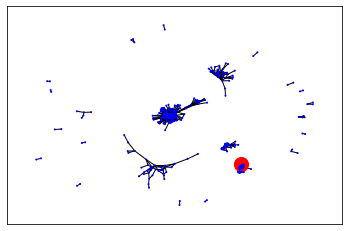

In [150]:
color_list_ita1970 = []
node_sizes_ita1970 = []
print(len(centr_degree_sorted_ita1970))
for i in range(0, len(centr_degree_sorted_ita1970)):
    if i == 0:
        color_list_ita1970.append("red")
        node_sizes_ita1970.append(200)
    elif i != 0:
        color_list_ita1970.append("blue")
        node_sizes_ita1970.append(1)

        
# Draw the network graph
pos = nx.spring_layout(network_italians1970)  # Choose a layout algorithm
nx.draw_networkx(network_italians1970, pos=pos, node_size = node_sizes_ita1970, node_color=color_list_ita1970, with_labels=False)

# Show the plot
plt.show()

## Italians born since 1950 (italian wikipedia)

In [103]:
filename="italians1950it.json"
if not os.path.isfile(filename):
    people=filter_persons_by(nationality="italy", birth_more=1950)
    fill_in_genders(people)
    save_people_json(people,filename)
    
italians1950it=load_people_json(filename)

print (len(italians1950it))
while fetch_summaries(italians1950it,batch_size=1188, lang = "it"): save_people_json(italians1950it,filename)
while fetch_langs(italians1950it,batch_size=1188, lang = "it"): save_people_json(italians1950it,filename)
while fetch_links(italians1950it,batch_size=1188, lang = "it"): save_people_json(italians1950it,filename)


save_people_json(italians1950it,filename)

1188
Fetching summary text data from Wikipedia


  0%|          | 0/1188 [00:00<?, ?it/s]

Fetching language editions data from Wikipedia


  0%|          | 0/1188 [00:00<?, ?it/s]

Fetching link data from Wikipedia


  0%|          | 0/1188 [00:00<?, ?it/s]

In [104]:
first_key = next(iter(italians1950it))
first_value = italians1950it[first_key]

print(first_key)  # Output: key1
print(first_value)  # Output: value1

Taismary_Agüero
{'#DBpURL': 'http://dbpedia.org/resource/Taismary_Agüero', 'ID': '8245', 'WikiURL': 'http://en.wikipedia.org/wiki/Taismary_Agüero', 'gender': 'NA', 'name': "[' taismary agüero ', ' taismary agüero leiva botteghi ', ' aguero taimarys ']", 'birthDate': "[' 1977-03-05 ']", 'deathDate': 'NA', 'occupation': 'NA', 'nationality': "[' italy ']", 'party': 'NA', 'summary': 'Taismary Agüero Leiva (Yaguajay, 5 marzo 1977) è una pallavolista cubana naturalizzata italiana.\nGioca nel ruolo di schiacciatrice e opposto nel Montale.', 'langs': ['de', 'en', 'es', 'fa', 'fr', 'ja', 'nb', 'pl', 'pt', 'ru', 'sv', 'tr', 'zh'], 'links': []}


In [105]:
female_ita1950 = 0
male_ita1950 = 0 
NA_ita1950 = 0
for italian in italians1950it: 
    if italians1950it[italian]["gender"] == "F":
        female_ita1950 +=1
    elif italians1950it[italian]["gender"] == "M":
        male_ita1950 +=1
    elif italians1950it[italian]["gender"] == "NA":
        NA_ita1970 += 1

print (len(italians1950it))
print ("number of female journalists:", female_ita1950)
print ("number of male journalists:", male_ita1950)
print ("number of NA journalists:", NA_ita1950)

1188
number of female journalists: 211
number of male journalists: 574
number of NA journalists: 0


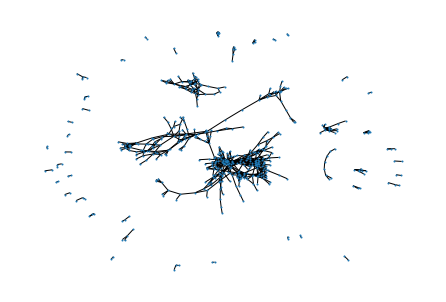

In [106]:
net_ita1950 = construct_network(italians1950it)

plt.figure()
positions = nx.spring_layout(net_ita1950)
nx.draw(net_ita1950, positions, node_size=1)

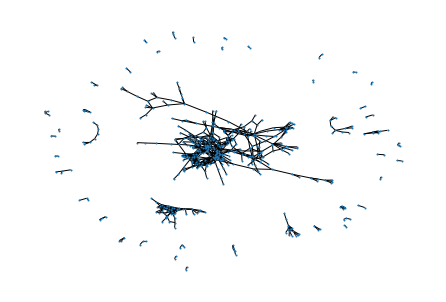

In [107]:
network_italians1950 = construct_network_dict(italians1950it)

plt.figure()
positions = nx.spring_layout(network_italians1950)
nx.draw(network_italians1950, positions, node_size=1)

The network has:
364 nodes
825 edges
4.532967032967033 average degree
0.3138724780857276 average clustering coefficient
4.1989961139896375 average shortest path lenght


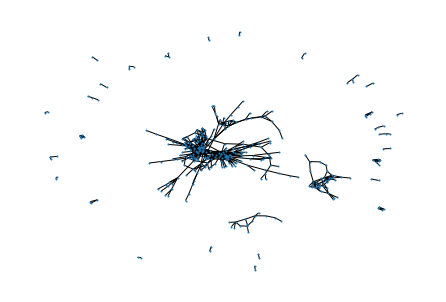

In [108]:
net_dictFM_ita1950 = construct_network_dictFM (italians1950it)

print("The network has:")
print(len(net_dictFM_ita1950), "nodes")
print(net_dictFM_ita1950.number_of_edges(), "edges")
print(2*net_dictFM_ita1950.number_of_edges()/len(net_dictFM_ita1950), "average degree")
print(nx.average_clustering(net_dictFM_ita1950), "average clustering coefficient")
print(nx.average_shortest_path_length(net_dictFM_ita1950.subgraph(max(nx.connected_components(net_dictFM_ita1950), key=len))), "average shortest path lenght")

plt.figure()
positions = nx.spring_layout(net_dictFM_ita1950)
nx.draw(net_dictFM_ita1950, positions, node_size=1)

In [109]:
male_ita1950, female_ita1950 = MaleFemaleDivision(italians1950it)
            
print (len(female_ita1950))
print (len(male_ita1950))
print (len(female_ita1950)+len(male_ita1950))

211
574
785


In [110]:
male_degree_ita1950 = nx.degree(net_ita1950, male_ita1950)

female_degree_ita1950 = nx.degree(net_ita1950, female_ita1950)

# Compute the average degree for males and females
average_male_degree = sum(dict(male_degree_ita1950).values()) / len(male_ita1950)
average_female_degree = sum(dict(female_degree_ita1950).values()) / len(female_ita1950)
print(average_male_degree)
print(average_female_degree)

2.102787456445993
2.8199052132701423


In [112]:
converted_dict_idf_ita1950 = idf (italians1950it)
#print (converted_dict_idf_journ)

In [113]:
allwords_female_ita1950, tf_female_ita1950 = tf_females_fun(female_ita1950)     
print (tf_female_ita1950)

{'di': 1.3127962085308056, 'è': 1.2938388625592416, 'e': 1.2464454976303319, 'italiana': 0.8388625592417062, 'del': 0.6161137440758294, 'in': 0.5734597156398105, 'una': 0.5213270142180095, 'ha': 0.4834123222748815, 'la': 0.4834123222748815, 'a': 0.4834123222748815, 'm': 0.44075829383886256, "un'ex": 0.41706161137440756, 'ed': 0.3933649289099526, 'nel': 0.3791469194312796, 'il': 0.36492890995260663, 'ai': 0.35071090047393366, 'con': 0.33175355450236965, 'vinto': 0.2890995260663507, 'della': 0.26066350710900477, 'indoor': 0.24644549763033174, 'un': 0.24170616113744076, 'nazionale': 0.23696682464454977, 'metri': 0.23696682464454977, 'titoli': 0.23696682464454977, 'per': 0.23696682464454977, 'al': 0.23222748815165878, 'sui': 0.22748815165876776, 'stata': 0.22748815165876776, 'campionessa': 0.21800947867298578, 'italiani': 0.21800947867298578, 'medaglie': 0.2132701421800948, 'volte': 0.2132701421800948, 'giochi': 0.20853080568720378, 'record': 0.2037914691943128, 'due': 0.2037914691943128, 

In [114]:
allwords_male_ita1950, tf_male_ita1950 = tf_males_fun(male_ita1950)
print (tf_male_ita1950)

{'è': 1.0696864111498259, 'di': 1.0400696864111498, 'e': 0.9111498257839721, 'un': 0.8484320557491289, 'italiano': 0.8048780487804879, 'del': 0.4094076655052265, 'ex': 0.34668989547038326, 'nel': 0.33797909407665505, 'il': 0.3310104529616725, 'in': 0.30662020905923343, 'della': 0.30662020905923343, 'a': 0.27177700348432055, 'la': 0.2613240418118467, 'stato': 0.23867595818815332, 'con': 0.23867595818815332, '': 0.22473867595818817, 'ai': 0.18641114982578397, 'ha': 0.18641114982578397, 'campione': 0.1794425087108014, 'pilota': 0.17247386759581881, 'dei': 0.16376306620209058, 'per': 0.15853658536585366, 'metri': 0.15505226480836237, 'al': 0.15331010452961671, 'nella': 0.13937282229965156, 'medaglia': 0.13414634146341464, 'volte': 0.13414634146341464, 'dal': 0.11846689895470383, 'giochi': 0.11672473867595819, 'm': 0.11672473867595819, 'ed': 0.11498257839721254, 'che': 0.11498257839721254, '–': 0.11149825783972125, 'velocista': 0.10452961672473868, 'europei': 0.10278745644599303, 'nazionale

In [115]:
tf_idf_females_ita1950 = {}
for word in tf_female_ita1950:
    tf_idf_females_ita1950[word] = tf_female_ita1950[word]*converted_dict_idf_ita1950[word]

sorted_tf_idf_females_ita1950 = sorted(tf_idf_females_ita1950.items(), key=lambda x:x[1], reverse = True)
converted_dict_tf_idf_females_ita1950 = dict(sorted_tf_idf_females_ita1950)
print (converted_dict_tf_idf_females_ita1950)

{'italiana': 1.1082420687678665, "un'ex": 0.9631378437924618, 'm': 0.8441581465303984, 'una': 0.8359806837868188, 'ha': 0.7772089776190226, 'ed': 0.7601903218865327, 'vinto': 0.6959197042327095, 'in': 0.6910738770499418, 'stata': 0.6645255165640761, 'campionessa': 0.6620893870902835, 'la': 0.6265996890733222, 'sui': 0.61662452643539, 'medaglie': 0.6164299957598456, 'ai': 0.6144982203973587, 'a': 0.6105088373263382, 'italiani': 0.5965221307638374, 'titoli': 0.5936766638434141, 'indoor': 0.5754734944127284, 'assoluti': 0.5597899743843598, 'del': 0.5545084360905322, 'nazionale': 0.5412881408355094, 'record': 0.539886337186772, 'con': 0.5237619917367319, 'due': 0.4867923249327877, 'metri': 0.4856844972820272, 'il': 0.470782499217777, 'giochi': 0.4629830341454047, '100': 0.4514383542909654, 'volte': 0.45004546926822997, 'per': 0.4318794141930826, 'medaglia': 0.42535442520779376, 'campionati': 0.42196206423321037, 'al': 0.41845346063465205, 'bronzo': 0.4139889941980814, 'nel': 0.412724911019

In [120]:
male_female_links_ita1950 = 0
for node in net_ita1950.nodes():
    if italians1950it[node]["gender"] == 'M':
        for link in italians1950it[node]["links"]:
            if (italians1950it[link]["gender"] == 'F'):
                male_female_links_ita1950 += 1

print (male_female_links_ita1950)

180


In [121]:
generic_links_ita1950 = 0
links_ita1950 = []
for node in net_ita1950.nodes():
    for link in italians1950it[node]["links"]:
        if (link, node) not in links_ita1950:

            generic_links_ita1950 += 1
            links_ita1950.append((node, link))

print (len(links_ita1950))
print (generic_links_ita1950)

1033
1033


In [124]:
#Local heroes if < 3 languages
Local_heroes_bound = 2
Female_local_heroes_ita1950 = 0
Male_local_heroes_ita1950 = 0

for node in net_ita1950.nodes():
    if italians1950it[node]["gender"] == 'M':
        if len(italians1950it[node]["langs"]) < Local_heroes_bound:
            Male_local_heroes_ita1950 +=1

print (Male_local_heroes_ita1950)
print (Male_local_heroes_ita1950/len(male_ita1950))

for node in net_ita1950.nodes():
    if italians1950it[node]["gender"] == 'F':
        if len(italians1950it[node]["langs"]) < Local_heroes_bound:
            Female_local_heroes_ita1950 +=1

print (Female_local_heroes_ita1950)
print (Female_local_heroes_ita1950/len(female_ita1950))

17
0.029616724738675958
9
0.04265402843601896


In [132]:
#italians 1950 in italian
 
def gender_words_female_italian(allwords):
    female_gender_words = 0

    female_gender_words += allwords["lei"]
    #female_gender_words += allwords["madre"]
    #female_gender_words += allwords["moglie"]

    return female_gender_words
    
female_gender_words_ita1950 = gender_words_female_italian(allwords_female_ita1950)
female_gender_words_average_ita1950 = female_gender_words_ita1950/len(female_ita1950)

print("female gender words in italians born since 1950: ", female_gender_words_ita1950)
print("female gender words average in italians born since 1950: ", female_gender_words_average_ita1950)

#personal life: father, daughter, married, husband, son

def pers_words_females_italian(allwords):
    female_pers_life_words = 0

    female_pers_life_words += allwords["padre"]
    #female_pers_life_words += allwords["figlia"]
    female_pers_life_words += allwords["sposata"]
    #female_pers_life_words += allwords["marito"]
    #female_pers_life_words += allwords["figlio"]

    return female_pers_life_words

female_pers_life_words_ita1950 = pers_words_females_italian(allwords_female_ita1950)

female_pers_life_words_average_ita1950 = female_pers_life_words_ita1950/len(female_ita1950)

print("female personal life words in italians born since 1950: ", female_pers_life_words_ita1950)
print("female personal life words average in italians born since 1950: ", female_pers_life_words_average_ita1950)

#occupations

def occupations(people):

    occupations = {}
    for person in people: 
        if people[person]["occupation"] in occupations:
            occupations[people[person]["occupation"]] += 1
        else: 
            occupations[people[person]["occupation"]] = 1
    return occupations

occupations_females = occupations(female_ita1950)

print("occupations: ", occupations_females)

female gender words in italians born since 1950:  2
female gender words average in italians born since 1950:  0.009478672985781991
female personal life words in italians born since 1950:  3
female personal life words average in italians born since 1950:  0.014218009478672985
occupations:  {'NA': 180, "[' archery ', ' archer ']": 3, "[' journalist ']": 1, "[' screenwriter ', ' actress director producer screenwriter ']": 1, "[' student ', ' student ']": 1, "[' showgirl television presenter ']": 1, "[' artist ', ' film producer ', ' artistfilm producer ']": 1, "[' actor ']": 1, "[' palaeography ', ' paleographer ']": 1, "[' model (people) ', ' actor ', ' showgirl ', ' fashion design ', ' modelactressshowgirlfashion designer ']": 1, "[' television host ex model ']": 1, "[' professional dancer ']": 1, "[' television host journalist ']": 1, "[' actress ']": 3, "[' tv host former actress ']": 1, "[' mountaineering ', ' nursemountaineer ']": 1, "[' ballet dancer ', ' actress ballerina ']": 1, 

In [137]:
#italians 1950 in italian
 
def gender_words_male_italian(allwords):
    male_gender_words = 0

    male_gender_words += allwords["lui"]
    male_gender_words += allwords["padre"]
    male_gender_words += allwords["marito"]

    return male_gender_words
    
male_gender_words_ita1950 = gender_words_male_italian(allwords_male_ita1950)
male_gender_words_average_ita1950 = male_gender_words_ita1950/len(male_ita1950)

print("male gender words in italians born since 1950: ", male_gender_words_ita1950)
print("male gender words average in italians born since 1950: ", male_gender_words_average_ita1950)

#personal life

def pers_words_males_italian(allwords):
    male_pers_life_words = 0

    male_pers_life_words += allwords["madre"]
    #male_pers_life_words += allwords["figlia"]
    #male_pers_life_words += allwords["sposato"]
    #male_pers_life_words += allwords["moglie"]
    male_pers_life_words += allwords["figlio"]

    return male_pers_life_words

male_pers_life_words_ita1950 = pers_words_males_italian(allwords_male_ita1950)

male_pers_life_words_average_ita1950 = male_pers_life_words_ita1950/len(male_ita1950)

print("female personal life words in italians born since 1950: ", male_pers_life_words_ita1950)
print("female personal life words average in italians born since 1950: ", male_pers_life_words_average_ita1950)

occupations_males = occupations(male_ita1950)

print("occupations: ", occupations_males)

male gender words in italians born since 1950:  14
male gender words average in italians born since 1950:  0.024390243902439025
female personal life words in italians born since 1950:  8
female personal life words average in italians born since 1950:  0.013937282229965157
occupations:  {'NA': 526, "[' director of football ', ' chief executive officer ', ' juventus fc ', ' director generaland sports department ', ' ceo ', ' of ', ' juventus fc ']": 1, "[' curator ', ' art curator ']": 1, "[' fiat chrysler automobiles ', ' exor (company) ', ' chairmanfiat chrysler automobiles ', ' chairman and ceoexor ']": 1, "[' oil businessman ']": 1, "[' pilot (aeronautics) ', ' hang gliding ', ' aviator ', ' hang glider ']": 1, "[' film director and producer ']": 1, "[' freediving ', ' athletic professor professionalfreediver tv host ']": 1, "[' radio host actor comedian ']": 1, "[' alpini ', ' mountaineering ', ' alpino mountaineer ']": 1, "[' politician ']": 1, "[' singer-songwriter ']": 1, "[' act

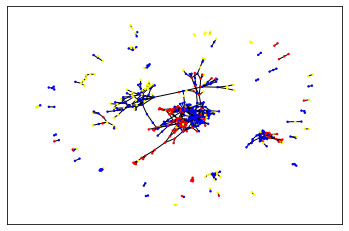

In [145]:
node_colors_ita1950 = []
for node in network_italians1950.nodes():
    if network_italians1950.nodes[node]["attr_dict"]["gender"] == "M":
        node_colors_ita1950.append("blue")
    elif network_italians1950.nodes[node]["attr_dict"]["gender"] == "F":
        node_colors_ita1950.append("red")
    else :
        node_colors_ita1950.append("yellow")

# Draw the network graph
pos = nx.spring_layout(network_italians1950)  # Choose a layout algorithm
nx.draw_networkx(network_italians1950, pos=pos, node_size = 2, node_color=node_colors_ita1950, with_labels=False)

# Show the plot
plt.show()

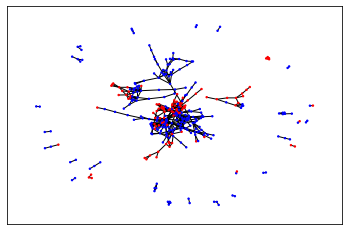

In [147]:
#division per gender

node_colors_ita1950 = []
for node in net_dictFM_ita1950.nodes():
    if net_dictFM_ita1950.nodes[node]["attr_dict"]["gender"] == "M":
        node_colors_ita1950.append("blue")
    elif net_dictFM_ita1950.nodes[node]["attr_dict"]["gender"] == "F":
        node_colors_ita1950.append("red")
        
# Draw the network graph
pos = nx.spring_layout(net_dictFM_ita1950)  # Choose a layout algorithm
nx.draw_networkx(net_dictFM_ita1950, pos=pos, node_size = 2, node_color=node_colors_ita1950, with_labels=False)

# Show the plot
plt.show()

In [156]:
centr_degree_ita1950 = nx.degree_centrality(network_italians1950)
centr_degree_sorted_ita1950=dict(sorted(centr_degree_ita1950.items(), key=lambda item: item[1],reverse=True))

for person in centr_degree_sorted_ita1950:
    print (person, centr_degree_sorted_ita1950[person], network_italians1950.nodes[person]["attr_dict"]["gender"])
       
#print (centr_degree_sorted_ita1950)

Matteo_Galvan 0.06286836935166994 M
Pietro_Mennea 0.058939096267190565 M
Davide_Manenti 0.05304518664047151 M
Paolo_Camossi 0.04715127701375245 M
Alessandro_Andrei 0.043222003929273084 M
Gennaro_Di_Napoli 0.043222003929273084 M
Maurizio_Damilano 0.043222003929273084 M
Alessia_Trost 0.043222003929273084 F
Maria_Benedicta_Chigbolu 0.043222003929273084 F
Yadisleidy_Pedroso 0.041257367387033395 F
Alessandro_Lambruschini 0.041257367387033395 M
Fiona_May 0.041257367387033395 F
Giuseppe_Gibilisco 0.041257367387033395 M
Dariya_Derkach 0.041257367387033395 F
Marzia_Caravelli 0.041257367387033395 F
Gabriella_Dorio 0.03929273084479371 F
Francesco_Panetta 0.03929273084479371 M
Ivano_Brugnetti 0.03929273084479371 M
Salvatore_Antibo 0.03929273084479371 M
Stefano_Baldini 0.03929273084479371 M
Fabrizio_Donato 0.03929273084479371 M
Alberto_Cova 0.03732809430255402 M
Gelindo_Bordin 0.03732809430255402 M
Maria_Enrica_Spacca 0.03732809430255402 F
Annarita_Sidoti 0.03536345776031434 F
Fabrizio_Mori 0.03536

510


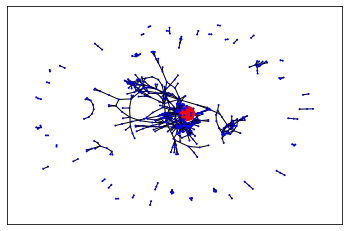

In [159]:
color_list_ita1950 = []
node_sizes_ita1950 = []
print(len(centr_degree_sorted_ita1950))
for i in range(0, len(centr_degree_sorted_ita1950)):
    if i == 0:
        color_list_ita1950.append("red")
        node_sizes_ita1950.append(200)
    elif i != 0:
        color_list_ita1950.append("blue")
        node_sizes_ita1950.append(1)

        
# Draw the network graph
pos = nx.spring_layout(network_italians1950)  # Choose a layout algorithm
nx.draw_networkx(network_italians1950, pos=pos, node_size = node_sizes_ita1950, node_color=color_list_ita1950, with_labels=False)

# Show the plot
plt.show()